# 0.0 - Imports

In [1]:
import datetime
import json
import math
import pickle
import random
import warnings

import inflection
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
from boruta import BorutaPy
from IPython.core.display import HTML
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from pandas.plotting import table
from scipy import stats as ss
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, RobustScaler
from tabulate import tabulate

## 0.1 - Helper Functions

In [2]:
def jupyter_settings():
    plt.style.use("bmh")
    plt.rcParams["figure.figsize"] = [25, 12]
    plt.rcParams["font.size"] = 24

    display(HTML("<style>.container { width:100% !important; }</style>"))
    pd.options.display.max_columns = 50
    pd.options.display.max_rows = 50
    pd.set_option("display.expand_frame_repr", False)

    sns.set()
    warnings.filterwarnings("ignore")

    return None


jupyter_settings()

In [3]:
# Cramer V function
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k - 1) * (r - 1) / (n - 1))
    kcorr = k - (k - 1) ** 2 / (n - 1)
    rcorr = r - (r - 1) ** 2 / (n - 1)

    return np.sqrt((chi2corr / n) / (min(kcorr - 1, rcorr - 1)))

In [4]:
# Clean dataset functions
def rename_cols(dataframe):
    # Rename columns
    cols_old = list(dataframe)
    # Function from rename
    snakecase = lambda x: inflection.underscore(x)
    cols_new = list(map(snakecase, cols_old))
    # Renaming columns
    dataframe.columns = cols_new

    return dataframe


def fillout_na(dataframe):
    # Fix date type
    dataframe["date"] = pd.to_datetime(dataframe["date"])

    # Fillout Na's
    dataframe["competition_distance"] = dataframe["competition_distance"].apply(
        lambda x: 200000.0 if math.isnan(x) else x
    )
    # competition_open_since_month
    dataframe["competition_open_since_month"] = dataframe.apply(
        lambda x: x["date"].month
        if math.isnan(x["competition_open_since_month"])
        else x["competition_open_since_month"],
        axis=1,
    )
    # competition_open_since_year
    dataframe["competition_open_since_year"] = dataframe.apply(
        lambda x: x["date"].year
        if math.isnan(x["competition_open_since_year"])
        else x["competition_open_since_year"],
        axis=1,
    )
    # promo2_since_week
    dataframe["promo2_since_week"] = dataframe.apply(
        lambda x: x["date"].week
        if math.isnan(x["promo2_since_week"])
        else x["promo2_since_week"],
        axis=1,
    )
    # promo2_since_year
    dataframe["promo2_since_year"] = dataframe.apply(
        lambda x: x["date"].year
        if math.isnan(x["promo2_since_year"])
        else x["promo2_since_year"],
        axis=1,
    )
    # promo_interval
    month_map = {
        1: "Jan",
        2: "Fev",
        3: "Mar",
        4: "Apr",
        5: "May",
        6: "Jun",
        7: "Jul",
        8: "Aug",
        9: "Sep",
        10: "Oct",
        11: "Nov",
        12: "Dec",
    }
    dataframe["promo_interval"].fillna(0, inplace=True)
    dataframe["month_map"] = dataframe["date"].dt.month.map(month_map)
    dataframe["is_promo"] = dataframe[["promo_interval", "month_map"]].apply(
        lambda x: 0
        if x["promo_interval"] == 0
        else 1
        if x["month_map"] in x["promo_interval"].split(",")
        else 0,
        axis=1,
    )
    return dataframe


def change_types(dataframe):
    dataframe["competition_open_since_month"] = dataframe[
        "competition_open_since_month"
    ].astype(int)
    dataframe["competition_open_since_year"] = dataframe[
        "competition_open_since_year"
    ].astype(int)
    dataframe["promo2_since_week"] = dataframe["promo2_since_week"].astype(int)
    dataframe["promo2_since_year"] = dataframe["promo2_since_year"].astype(int)

    return dataframe


def feature_eng(dataframe):
    # Creating datetimes
    # Year
    dataframe["year"] = dataframe["date"].dt.year

    # Month
    dataframe["month"] = dataframe["date"].dt.month

    # Day
    dataframe["day"] = dataframe["date"].dt.day

    # Week of Year
    dataframe["week_of_year"] = dataframe["date"].dt.isocalendar().week

    # Year Week
    dataframe["year_week"] = dataframe["date"].dt.strftime("%Y-%W")

    dataframe["competition_since"] = dataframe.apply(
        lambda x: datetime.datetime(
            year=x["competition_open_since_year"],
            month=x["competition_open_since_month"],
            day=1,
        ),
        axis=1,
    )
    dataframe["competition_time_month"] = (
        ((dataframe["date"] - dataframe["competition_since"]) / 30)
        .apply(lambda x: x.days)
        .astype(int)
    )

    # Promo Since
    dataframe["promo_since"] = (
        dataframe["promo2_since_year"].astype(str)
        + "-"
        + dataframe["promo2_since_week"].astype(str)
    )
    dataframe["promo_since"] = dataframe["promo_since"].apply(
        lambda x: datetime.datetime.strptime(x + "-1", "%Y-%W-%w")
        - datetime.timedelta(days=7)
    )
    dataframe["promo_time_week"] = (
        ((dataframe["date"] - dataframe["promo_since"]) / 7)
        .apply(lambda x: x.days)
        .astype(int)
    )

    # Assortment
    dataframe["assortment"] = dataframe["assortment"].apply(
        lambda x: "basic" if x == "a" else "extra" if x == "b" else "extended"
    )

    # State Holiday
    dataframe["state_holiday"] = dataframe["state_holiday"].apply(
        lambda x: "public_holiday"
        if x == "a"
        else "easter_holiday"
        if x == "b"
        else "christmas"
        if x == "c"
        else "regular_day"
    )

    return dataframe


def filter_features(dataframe):
    # Filter lines
    dataframe = dataframe.loc[(dataframe["open"] != 0) & (dataframe["sales"] > 0), :]

    # Filter columns
    dataframe = dataframe.drop(
        ["customers", "open", "promo_interval", "month_map"], axis=1
    )

    return dataframe


def data_preparation(dataframe):
    # Rescaling
    rs = RobustScaler()
    mms = MinMaxScaler()

    # competition distance
    dataframe["competition_distance"] = rs.fit_transform(
        dataframe[["competition_distance"]].values
    )

    # competition time month
    dataframe["competition_time_month"] = rs.fit_transform(
        dataframe[["competition_time_month"]].values
    )

    # promo time week
    dataframe["promo_time_week"] = mms.fit_transform(
        dataframe[["promo_time_week"]].values
    )

    # year
    dataframe["year"] = mms.fit_transform(dataframe[["year"]].values)

    # Encoding
    # state holiday - One Hot Encoding
    dataframe = pd.get_dummies(
        dataframe, prefix=["state_holiday"], columns=["state_holiday"]
    )

    # store type - Label Encoder
    le = LabelEncoder()
    dataframe["store_type"] = le.fit_transform(dataframe["store_type"])

    # assortment
    assortment_dict = {
        "basic": 1,
        "extra": 2,
        "extended": 3,
    }

    dataframe["assortment"] = dataframe["assortment"].map(assortment_dict)

    # Target Variable Transformation
    dataframe["sales"] = np.log1p(dataframe["sales"])

    # Natural Transformation
    # month
    dataframe["month_sin"] = dataframe["month"].apply(
        lambda x: np.sin(x * (2.0 * np.pi / 12))
    )
    dataframe["month_cos"] = dataframe["month"].apply(
        lambda x: np.cos(x * (2.0 * np.pi / 12))
    )

    # day
    dataframe["day_sin"] = dataframe["day"].apply(
        lambda x: np.sin(x * (2.0 * np.pi / 30))
    )
    dataframe["day_cos"] = dataframe["day"].apply(
        lambda x: np.cos(x * (2.0 * np.pi / 30))
    )

    # day of week
    dataframe["day_of_week_sin"] = dataframe["day_of_week"].apply(
        lambda x: np.sin(x * (2.0 * np.pi / 7))
    )
    dataframe["day_of_week_cos"] = dataframe["day_of_week"].apply(
        lambda x: np.cos(x * (2.0 * np.pi / 7))
    )

    # week of year
    dataframe["week_of_year_sin"] = dataframe["week_of_year"].apply(
        lambda x: np.sin(x * (2.0 * np.pi / 52))
    )
    dataframe["week_of_year_cos"] = dataframe["week_of_year"].apply(
        lambda x: np.cos(x * (2.0 * np.pi / 52))
    )

    dataframe = dataframe.drop(
        [
            "day_of_week",
            "day",
            "month",
            "week_of_year",
            "promo_since",
            "competition_since",
            "year_week",
        ],
        axis=1,
    )

    return dataframe

In [5]:
# Performance Metrics
def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))

    return pd.DataFrame(
        {
            "Model Name": model_name,
            "MAE": np.round(mae, 2),
            "MAPE": np.round(mape, 4),
            "RMSE": np.round(rmse, 2),
        },
        index=[0],
    )


def mean_percentage_error(y, y_hat):
    return np.mean((y - y_hat) / y)

In [6]:
# Time series cross validation function
def cross_validation(X_train, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed(range(1, kfold + 1)):
        # Start and end validation date
        validation_start_date = X_train["date"].max() - datetime.timedelta(
            days=k * 6 * 7
        )
        validation_end_date = X_train["date"].max() - datetime.timedelta(
            days=(k - 1) * 6 * 7
        )

        # filtering dataset
        training = X_train[X_train["date"] < validation_start_date]
        validation = X_train[
            (X_train["date"] >= validation_start_date)
            & (X_train["date"] <= validation_end_date)
        ]

        # training and validation dataset
        xtraining = training.drop(["date", "sales"], axis=1)
        ytraining = training["sales"]

        xvalidation = validation.drop(["date", "sales"], axis=1)
        yvalidation = validation["sales"]

        # model
        m = model.fit(xtraining, ytraining)

        # predict
        yhat_m = m.predict(xvalidation)

        # performance
        m_performance = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat_m))

        if verbose:
            print(f"K-Fold: {k}")
            print(f"\n{m_performance}")

        # store performance for each kfold
        mae_list.append(m_performance["MAE"])
        mape_list.append(m_performance["MAPE"])
        rmse_list.append(m_performance["RMSE"])

    return pd.DataFrame(
        {
            "Model Name": model_name,
            "MAE CV": np.round(np.mean(mae_list), 2).astype(str)
            + " +/- "
            + np.round(np.std(mae_list), 2).astype(str),
            "MAPE CV": np.round(np.mean(mape_list), 4).astype(str)
            + " +/- "
            + np.round(np.std(mape_list), 4).astype(str),
            "RMSE CV": np.round(np.mean(rmse_list), 2).astype(str)
            + " +/- "
            + np.round(np.std(rmse_list), 2).astype(str),
        },
        index=[0],
    )

## 0.2 - Load Data

In [7]:
df_sales_raw = pd.read_csv("../data/raw/train.csv")
df_store_raw = pd.read_csv("../data/raw/store.csv")

# Merging datasets
df_raw = pd.merge(df_sales_raw, df_store_raw, how="left", on="Store")

df_raw.sample(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
970260,996,2,2013-02-12,4364,592,1,0,0,1,c,a,2870.0,7.0,2015.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
905190,596,4,2013-04-11,4107,644,1,1,0,0,c,a,290.0,9.0,2006.0,0,NaN,NaN,NaN
401073,166,2,2014-07-08,4693,672,1,0,0,1,a,c,100.0,4.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
290636,30,1,2014-11-03,8271,1000,1,1,0,0,a,a,40.0,2.0,2014.0,1,10.0,2014.0,"Mar,Jun,Sept,Dec"
272346,521,7,2014-11-23,0,0,0,0,0,0,d,a,18610.0,11.0,2002.0,1,48.0,2011.0,"Mar,Jun,Sept,Dec"


## 0.3 - Split Data

In [8]:
# Separating 6 weeks for test dataset
df_raw["Date"] = pd.to_datetime(df_raw["Date"])

df_raw[["Store", "Date"]].groupby("Store").max().reset_index()["Date"][
    0
] - datetime.timedelta(days=6 * 7)

Timestamp('2015-06-19 00:00:00')

In [9]:
# split train and test
train = df_raw.loc[df_raw["Date"] < "2015-06-19", :]
test = df_raw.loc[df_raw["Date"] >= "2015-06-19", :]

In [10]:
print("Training Min Date: {}".format(train["Date"].min()))
print("Training Max Date: {}".format(train["Date"].max()))

print("\nTest Min Date: {}".format(test["Date"].min()))
print("Test Max Date: {}".format(test["Date"].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


# 1.0 - Data Description

In [11]:
# Creating dataset copy
df1 = df_raw.copy()

## 1.1 - Rename Columns

In [12]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [13]:
# Putting columns names on list
cols_old = list(df1)

# Function from rename
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

# Renaming columns
df1.columns = cols_new

# New columns names
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 - Data Dimension 

In [14]:
# Number of Rows and Columns
print(f"Number of Rows: {df1.shape[0]}")
print(f"Number of Columns: {df1.shape[1]}")

Number of Rows: 1017209
Number of Columns: 18


## 1.3 - Check Data Types 

In [15]:
# Checking types
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 - Check NA's 

In [16]:
# Checking sum of Na's
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 - Fillout NA

In [17]:
# competition_distance

# Fill with a big number that represents no competition
df1["competition_distance"] = df1["competition_distance"].apply(
    lambda x: 200000.0 if math.isnan(x) else x
)
# competition_open_since_month

# Fill with record date if there is no competition so de fiference from date to competition open is zero
df1["competition_open_since_month"] = df1.apply(
    lambda x: x["date"].month
    if math.isnan(x["competition_open_since_month"])
    else x["competition_open_since_month"],
    axis=1,
)
# competition_open_since_year
df1["competition_open_since_year"] = df1.apply(
    lambda x: x["date"].year
    if math.isnan(x["competition_open_since_year"])
    else x["competition_open_since_year"],
    axis=1,
)
# promo2_since_week
df1["promo2_since_week"] = df1.apply(
    lambda x: x["date"].week
    if math.isnan(x["promo2_since_week"])
    else x["promo2_since_week"],
    axis=1,
)
# promo2_since_year
df1["promo2_since_year"] = df1.apply(
    lambda x: x["date"].year
    if math.isnan(x["promo2_since_year"])
    else x["promo2_since_year"],
    axis=1,
)
# promo_interval
month_map = {
    1: "Jan",
    2: "Fev",
    3: "Mar",
    4: "Apr",
    5: "May",
    6: "Jun",
    7: "Jul",
    8: "Aug",
    9: "Sep",
    10: "Oct",
    11: "Nov",
    12: "Dec",
}
df1["promo_interval"].fillna(0, inplace=True)
df1["month_map"] = df1["date"].dt.month.map(month_map)
df1["is_promo"] = df1[["promo_interval", "month_map"]].apply(
    lambda x: 0
    if x["promo_interval"] == 0
    else 1
    if x["month_map"] in x["promo_interval"].split(",")
    else 0,
    axis=1,
)

In [18]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 - Change Types

In [19]:
df1["competition_open_since_month"] = df1["competition_open_since_month"].astype(int)
df1["competition_open_since_year"] = df1["competition_open_since_year"].astype(int)

df1["promo2_since_week"] = df1["promo2_since_week"].astype(int)
df1["promo2_since_year"] = df1["promo2_since_year"].astype(int)

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 - Descriptive Statistics

In [20]:
# Separating numeric from categorical variables
num_attributes = df1.select_dtypes(include=["int64", "float64"])
cat_attributes = df1.select_dtypes(exclude=["int64", "float64", "datetime64[ns]"])

cat_attributes.sample(5)

,state_holiday,store_type,assortment,promo_interval,month_map
610568,0,d,c,"Mar,Jun,Sept,Dec",Dec
114296,0,c,a,"Feb,May,Aug,Nov",Apr
392578,0,d,c,"Jan,Apr,Jul,Oct",Jul
71104,0,c,c,0,May
588271,0,d,c,"Feb,May,Aug,Nov",Jan


### 1.7.1 - Numerical Attributes

In [21]:
# Central tendencies, mean and median
ct_mean = pd.DataFrame(num_attributes.apply(np.mean)).T
ct_median = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion, std, min, max, range, skew and kurtosis
d_std = pd.DataFrame(num_attributes.apply(np.std)).T
d_min = pd.DataFrame(num_attributes.apply(min)).T
d_max = pd.DataFrame(num_attributes.apply(max)).T
d_range = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d_skew = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d_kurtosis = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenate
m = pd.concat(
    [d_min, d_max, d_range, ct_mean, ct_median, d_std, d_skew, d_kurtosis]
).T.reset_index()
m.columns = [
    "features",
    "min",
    "max",
    "range",
    "mean",
    "median",
    "std",
    "skew",
    "kurtosis",
]
m

,features,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


<Axes: xlabel='sales', ylabel='Density'>

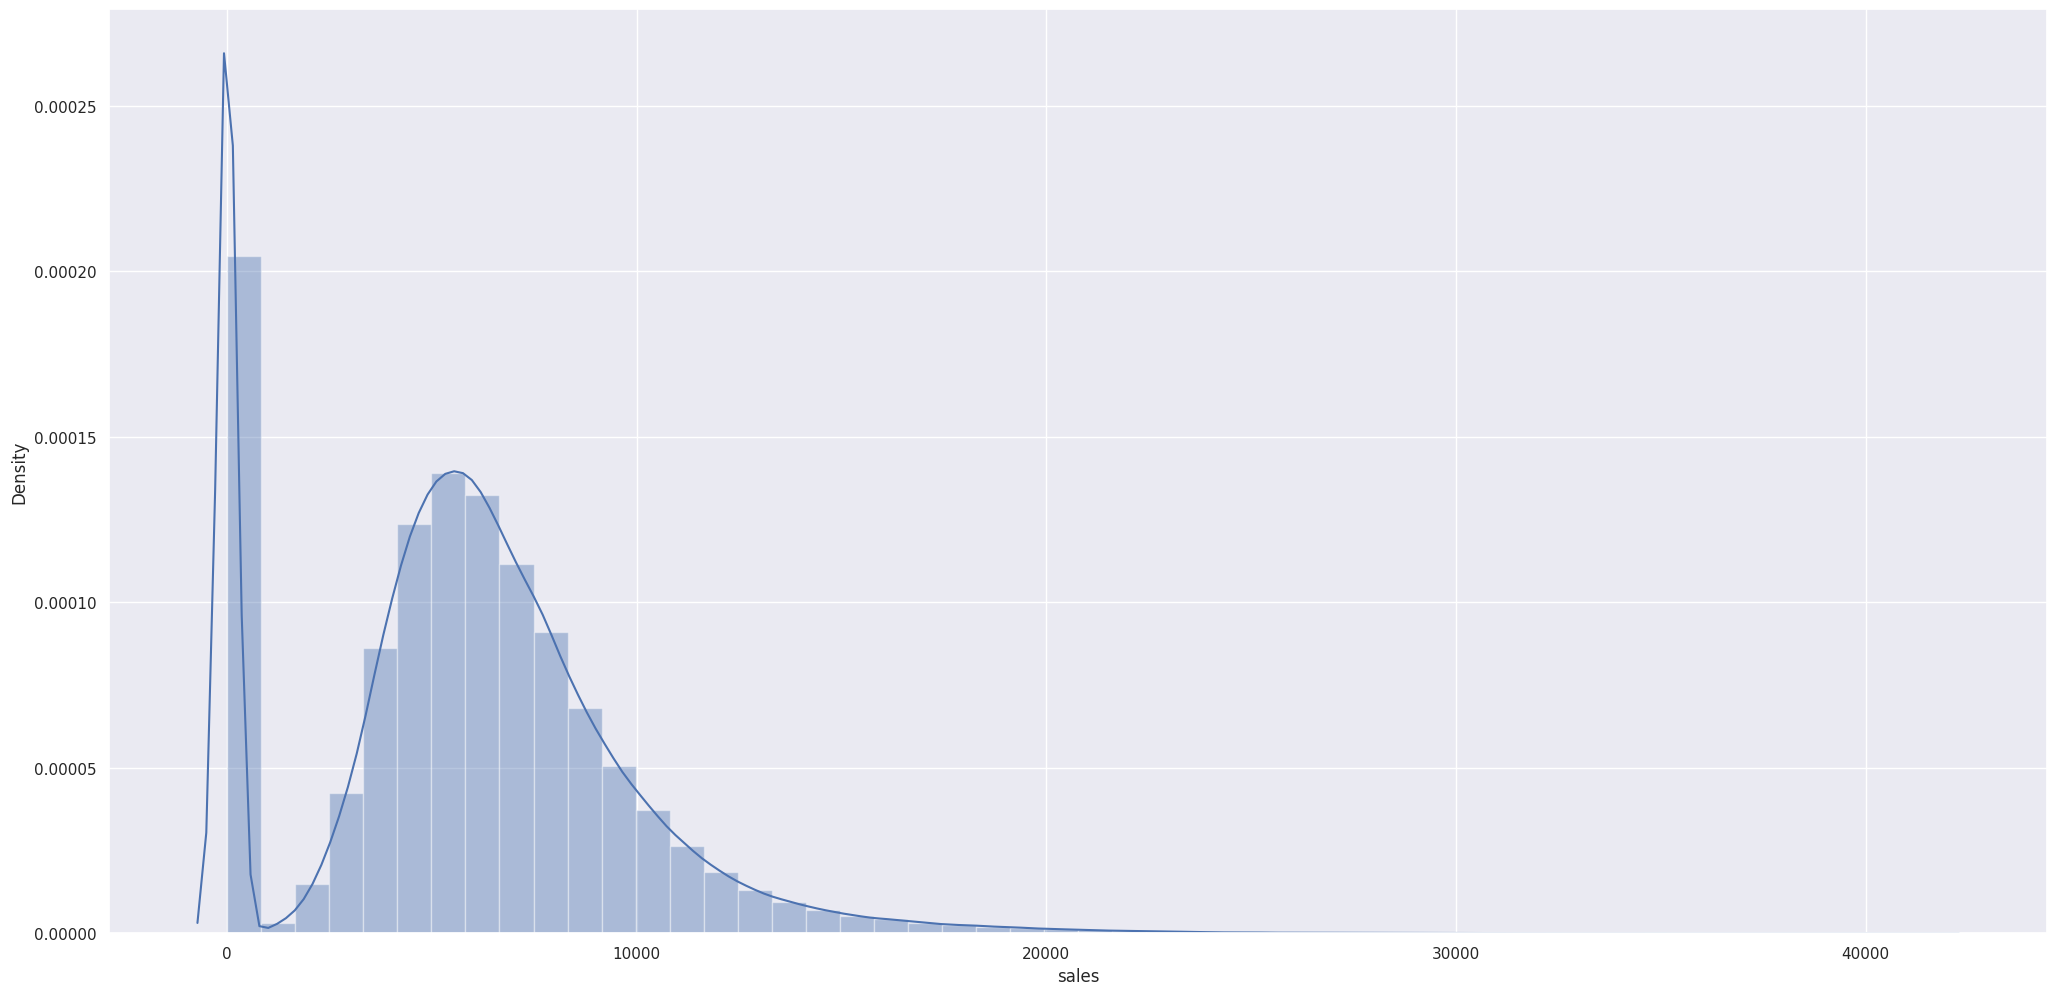

In [22]:
sns.distplot(df1["sales"])

<Axes: xlabel='competition_distance', ylabel='Density'>

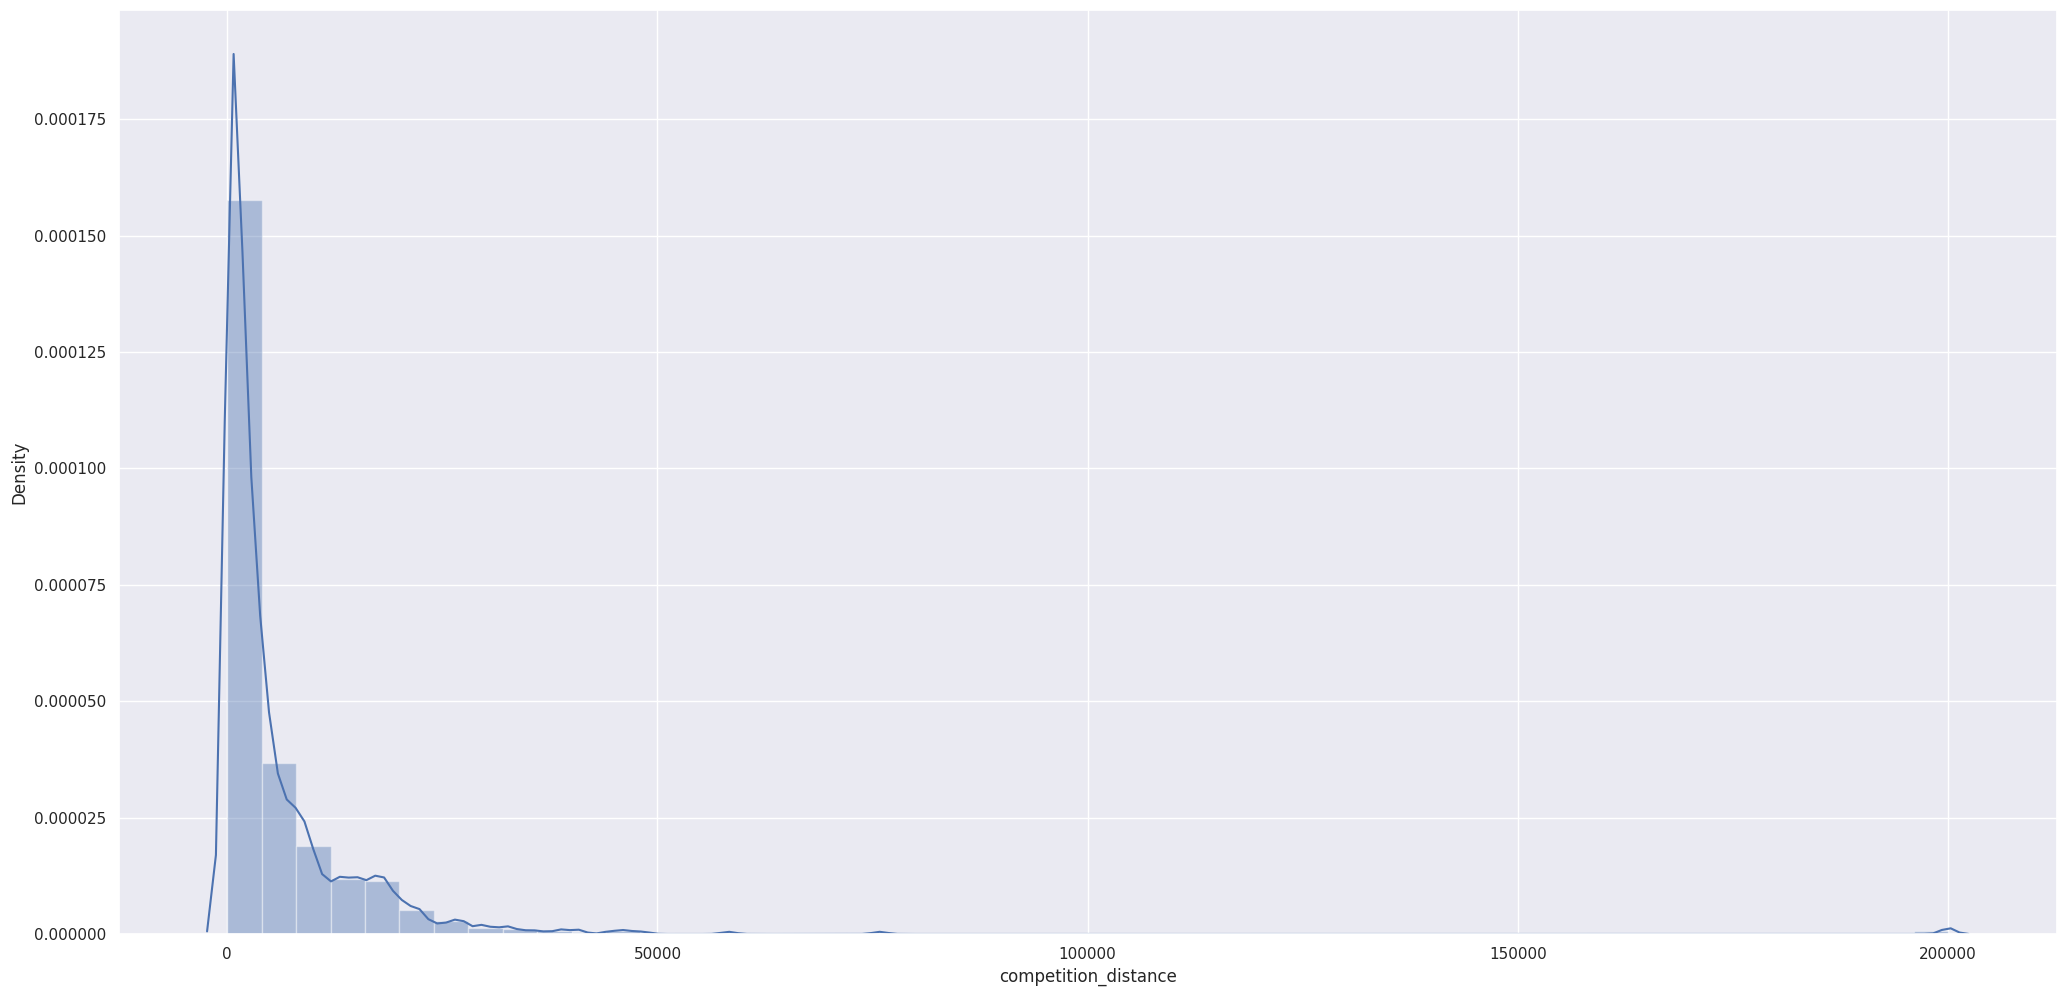

In [23]:
sns.distplot(df1["competition_distance"])

### 1.7.2 - Categorical Attributes

In [24]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      5
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<Axes: xlabel='assortment', ylabel='sales'>

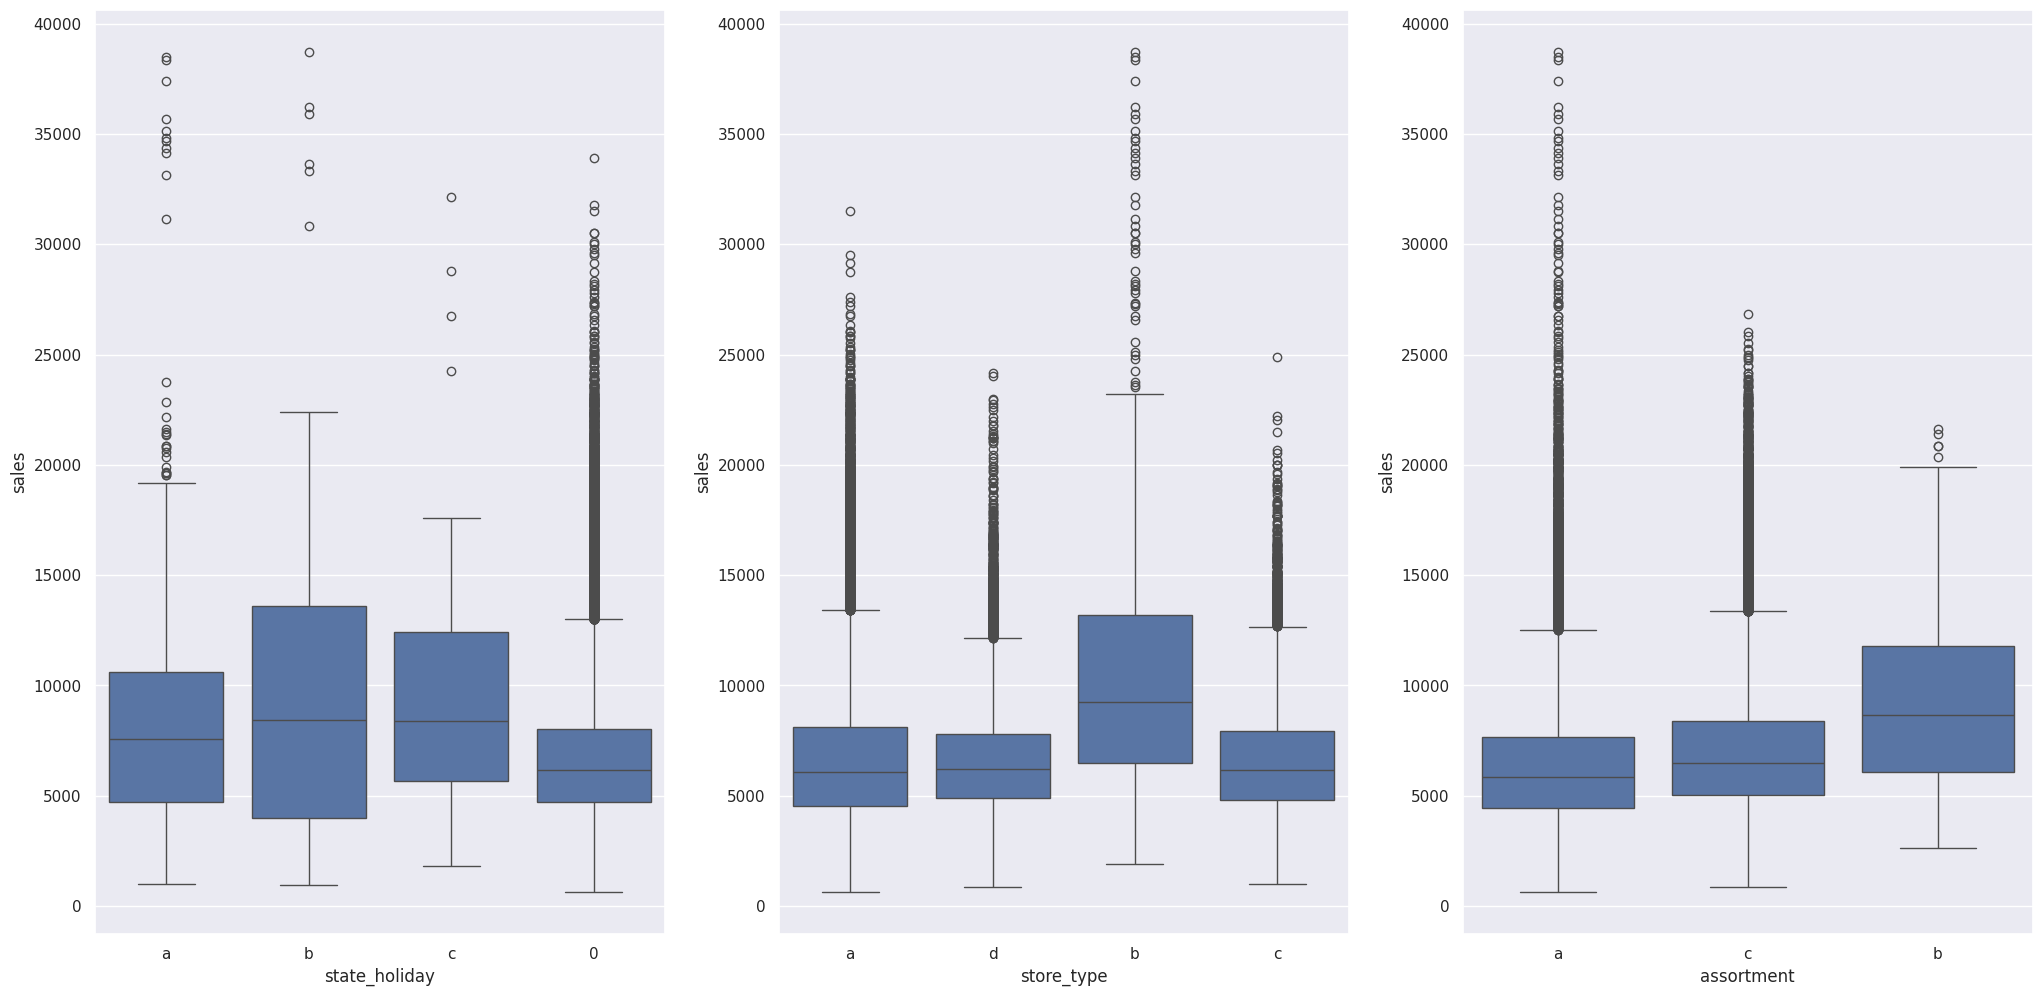

In [25]:
# Is this data leakage?
filters = (df1["state_holiday"] != "0") & (df1["sales"] > 0)
aux = df1.loc[filters, :]

plt.subplot(1, 3, 1)
sns.boxplot(x="state_holiday", y="sales", data=aux)
plt.subplot(1, 3, 2)
sns.boxplot(x="store_type", y="sales", data=aux)
plt.subplot(1, 3, 3)
sns.boxplot(x="assortment", y="sales", data=aux)

# 2.0 - Feature Engineering

In [26]:
df2 = df1.copy()

## 2.1 - Hypothesis Mind Map

```mermaid
mindmap
    [Daily Stores Sales]
        )Clients(
            Volume of Sales
            Number of Children
            Income
            Age
            Profession
            Family
            Purchase Frequency
        )Location(
            School Area
            Neighborhood
            Rural
            Urban
            Downtown
            Hospital Area
        )Time(
            Holiday
            Week of Year
            Day
            Month
            Year
            Hour
            Weekend
            Sale
        )Stores(
            Staff Size
            Supply
            Size
            Assortment
            Competition
        )Products(
            Marketing
            Disposition
            Price
            Supply
            Sale
```

## 2.2 - Hypothesis

### 2.2.1 - **Store** Hypothesis

**1.** Stores with more employess should sell more.  
**2.** Stores with bigger storage should sell more.  
**3.** Bigger stores should sell more.  
**4.** Stores with higher assortment should sell more.  
**5.** Stores with closer competitors should sell less.  
**6.** Stores with older competitors should sell more.  

### 2.2.2 - **Products** Hypothesis

**1.** Sores with higher marketing spending should sell more.  
**2.** Stores with bigger product display should sell more.  
**3.** Stores with cheaper products should sell more.  
**5.** Stores with more agressive discounts should sell more.  
**6.** Stores with longer active promotions should sell more.  
**7.** Stores with more promotion days should sell more.  
**8.** Stores with more consecutive promotions should sell more.  

### 2.2.3 - **Time** Hypothesis

**1.** Stores should sell more during christmas.  
**2.** Stores should sell more throughout the years.  
**3.** Stores should sell more on the second semester.  
**4.** Stores should sell more after 10th day of each month.  
**5.** Stores should sell less on weekends.  
**6.** Stores should sell less during school holidays.  

## 2.3 - Final Hypothesis

**1.** Stores with higher assortment should sell more.  
**2.** Stores with closer competitors should sell less.  
**3.** Stores with older competitors should sell more.  
**4.** Stores with longer active promotions should sell more.  
**5.** Stores with more promotion days should sell more.  
**6.** Stores with more consecutive promotions should sell more.  
**7.** Stores open during christmas should sell more.  
**8.** Stores should sell more throughout the years.  
**9.** Stores should sell more on the second semester.  
**10.** Stores should sell more after 10th day of each month.  
**11.** Stores should sell less on weekends.  
**12.** Stores should sell less during school holidays.  

## 2.4 - Feature Engineering

In [27]:
# Creating datetimes

# Year
df2["year"] = df2["date"].dt.year

# Month
df2["month"] = df2["date"].dt.month

# Day
df2["day"] = df2["date"].dt.day

# Week of Year
df2["week_of_year"] = df2["date"].dt.isocalendar().week

# Year Week
df2["year_week"] = df2["date"].dt.strftime("%Y-%W")

In [28]:
# Competition Since
df2["competition_since"] = df2.apply(
    lambda x: datetime.datetime(
        year=x["competition_open_since_year"],
        month=x["competition_open_since_month"],
        day=1,
    ),
    axis=1,
)
df2["competition_time_month"] = (
    ((df2["date"] - df2["competition_since"]) / 30).apply(lambda x: x.days).astype(int)
)

In [29]:
# Promo Since
df2["promo_since"] = (
    df2["promo2_since_year"].astype(str) + "-" + df2["promo2_since_week"].astype(str)
)
df2["promo_since"] = df2["promo_since"].apply(
    lambda x: datetime.datetime.strptime(x + "-1", "%Y-%W-%w")
    - datetime.timedelta(days=7)
)
df2["promo_time_week"] = (
    ((df2["date"] - df2["promo_since"]) / 7).apply(lambda x: x.days).astype(int)
)

In [30]:
# Assortment
df2["assortment"] = df2["assortment"].apply(
    lambda x: "basic" if x == "a" else "extra" if x == "b" else "extended"
)

# State Holiday
df2["state_holiday"] = df2["state_holiday"].apply(
    lambda x: "public_holiday"
    if x == "a"
    else "easter_holiday"
    if x == "b"
    else "christmas"
    if x == "c"
    else "regular_day"
)

# 3.0 - Feature Filtering

In [31]:
df3 = df2.copy()

## 3.1 - Filtering Rows

In [32]:
df3 = df3.loc[(df3["open"] != 0) & (df3["sales"] > 0), :]

## 3.2 - Filtering Columns

In [33]:
# Selected only open stores and number of customers is a "leaky" variable
df3 = df3.drop(["customers", "open", "promo_interval", "month_map"], axis=1)
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 - Exploratory Data Analysis (EDA)

In [34]:
df4 = df3.copy()

## 4.1 - Univariate Analysis

### 4.1.1 - Response Variable

<Axes: xlabel='sales', ylabel='Count'>

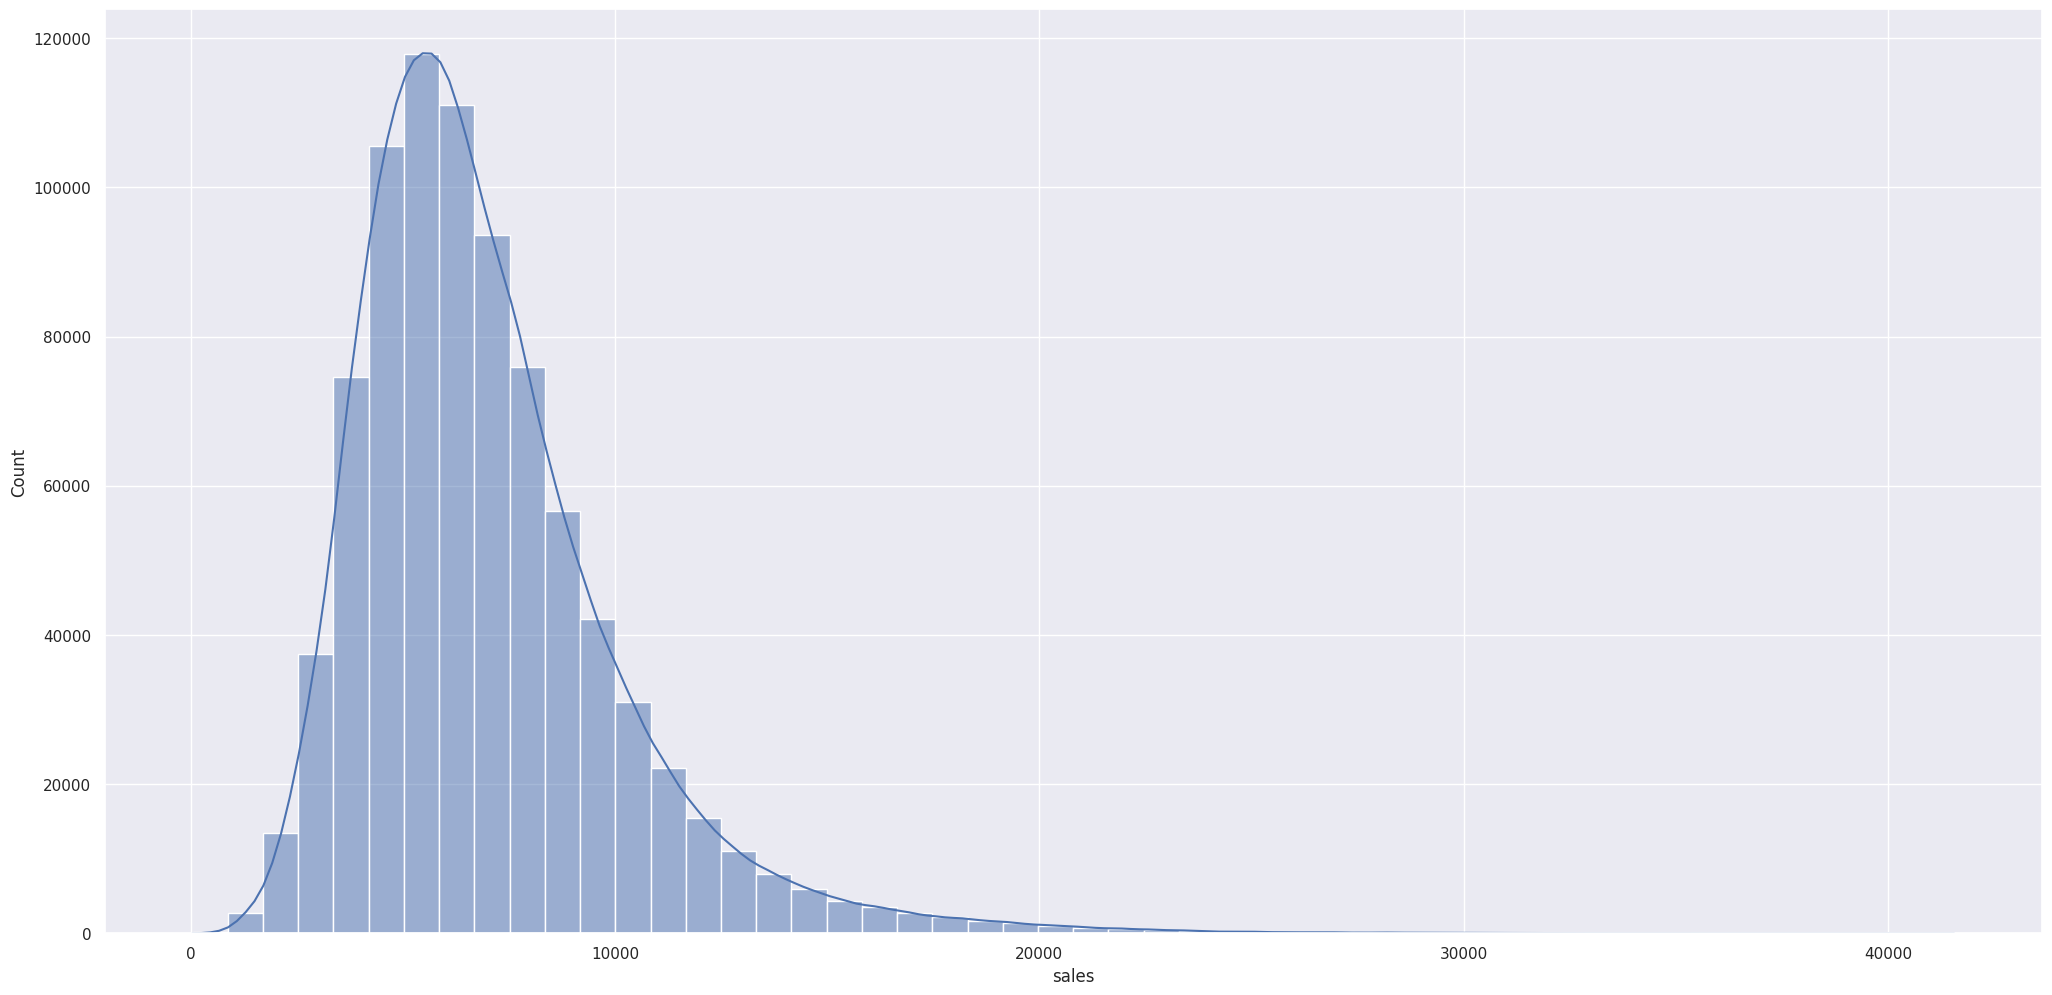

In [35]:
sns.histplot(df4["sales"], kde=True, bins=50)

### 4.1.2 - Numerical Attributes

array([[<Axes: title={'center': 'store'}>,
        <Axes: title={'center': 'day_of_week'}>,
        <Axes: title={'center': 'sales'}>,
        <Axes: title={'center': 'customers'}>],
       [<Axes: title={'center': 'open'}>,
        <Axes: title={'center': 'promo'}>,
        <Axes: title={'center': 'school_holiday'}>,
        <Axes: title={'center': 'competition_distance'}>],
       [<Axes: title={'center': 'competition_open_since_month'}>,
        <Axes: title={'center': 'competition_open_since_year'}>,
        <Axes: title={'center': 'promo2'}>,
        <Axes: title={'center': 'promo2_since_week'}>],
       [<Axes: title={'center': 'promo2_since_year'}>,
        <Axes: title={'center': 'is_promo'}>, <Axes: >, <Axes: >]],
      dtype=object)

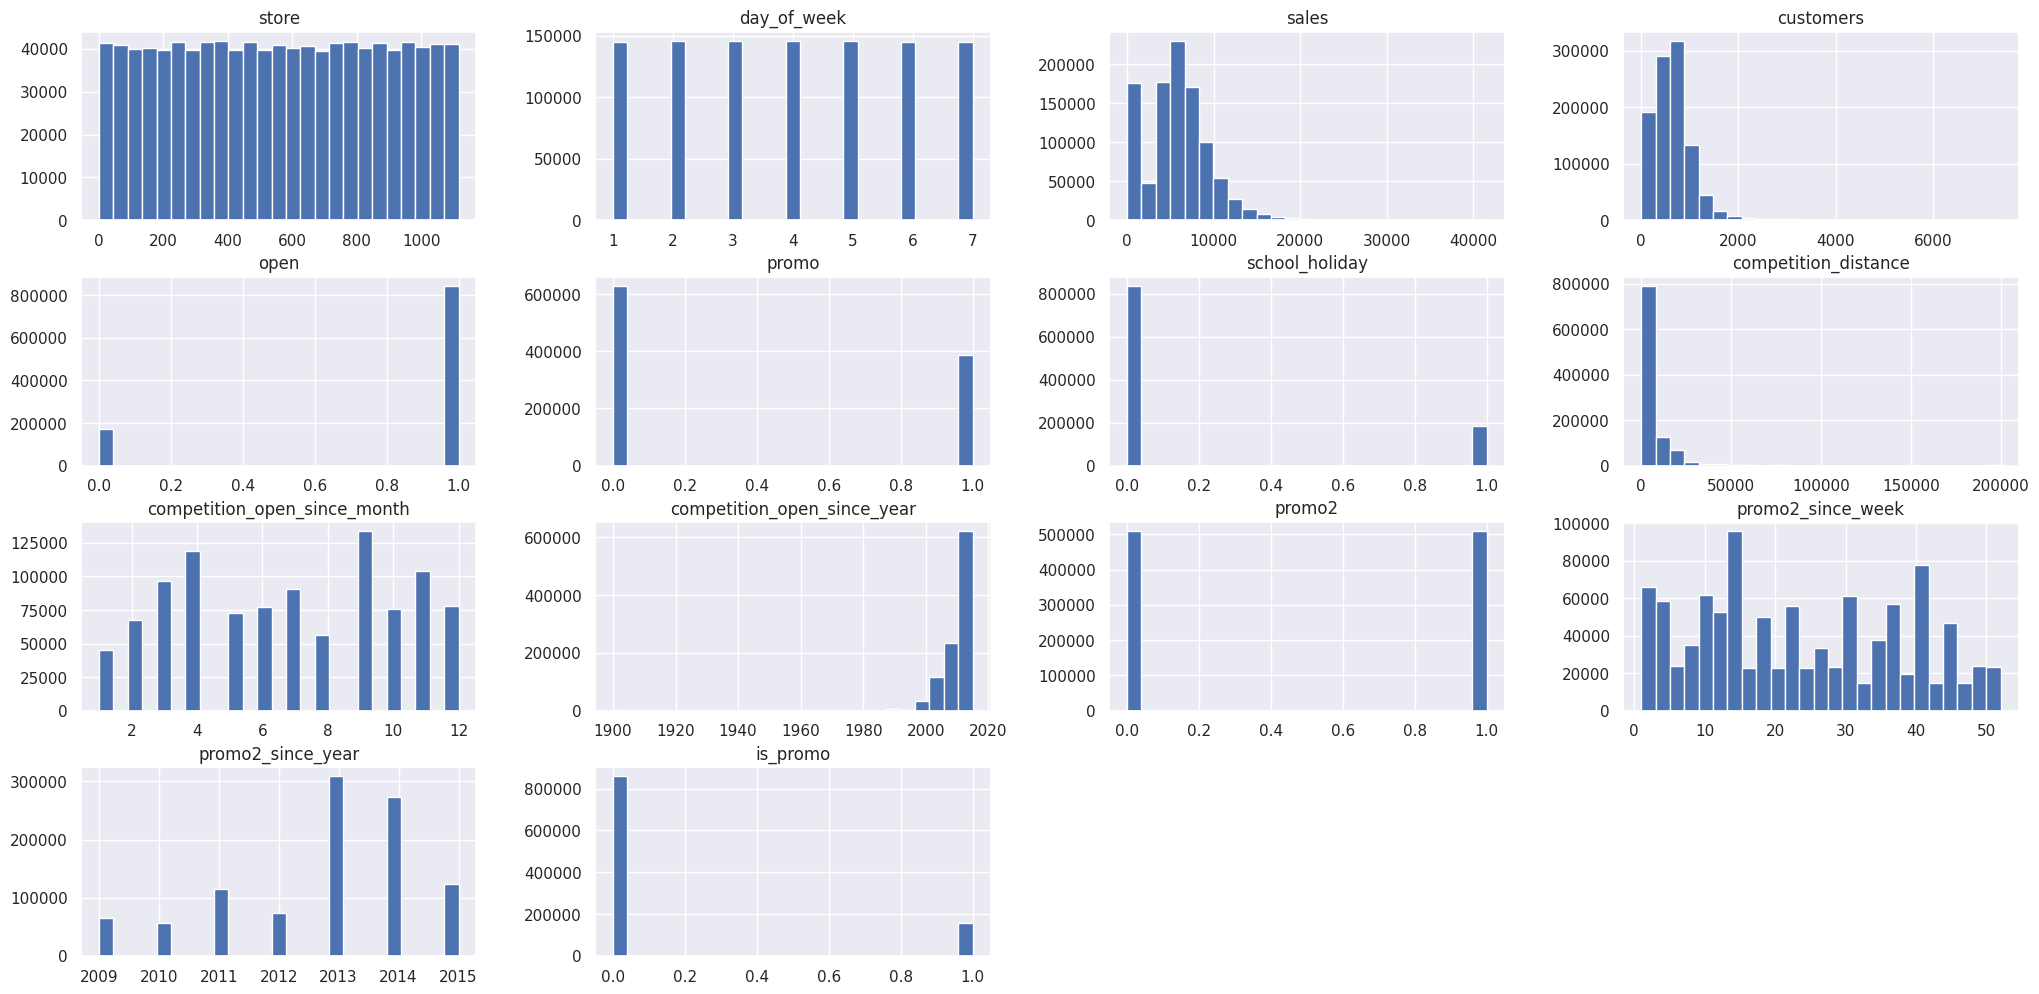

In [36]:
num_attributes.hist(bins=25)

### 4.1.3 - Categorical Attributes

In [37]:
df4["state_holiday"].unique()

array(['regular_day', 'public_holiday', 'easter_holiday', 'christmas'],
      dtype=object)

In [38]:
df4["store_type"].unique()

array(['c', 'a', 'd', 'b'], dtype=object)

In [39]:
df4["assortment"].unique()

array(['basic', 'extended', 'extra'], dtype=object)

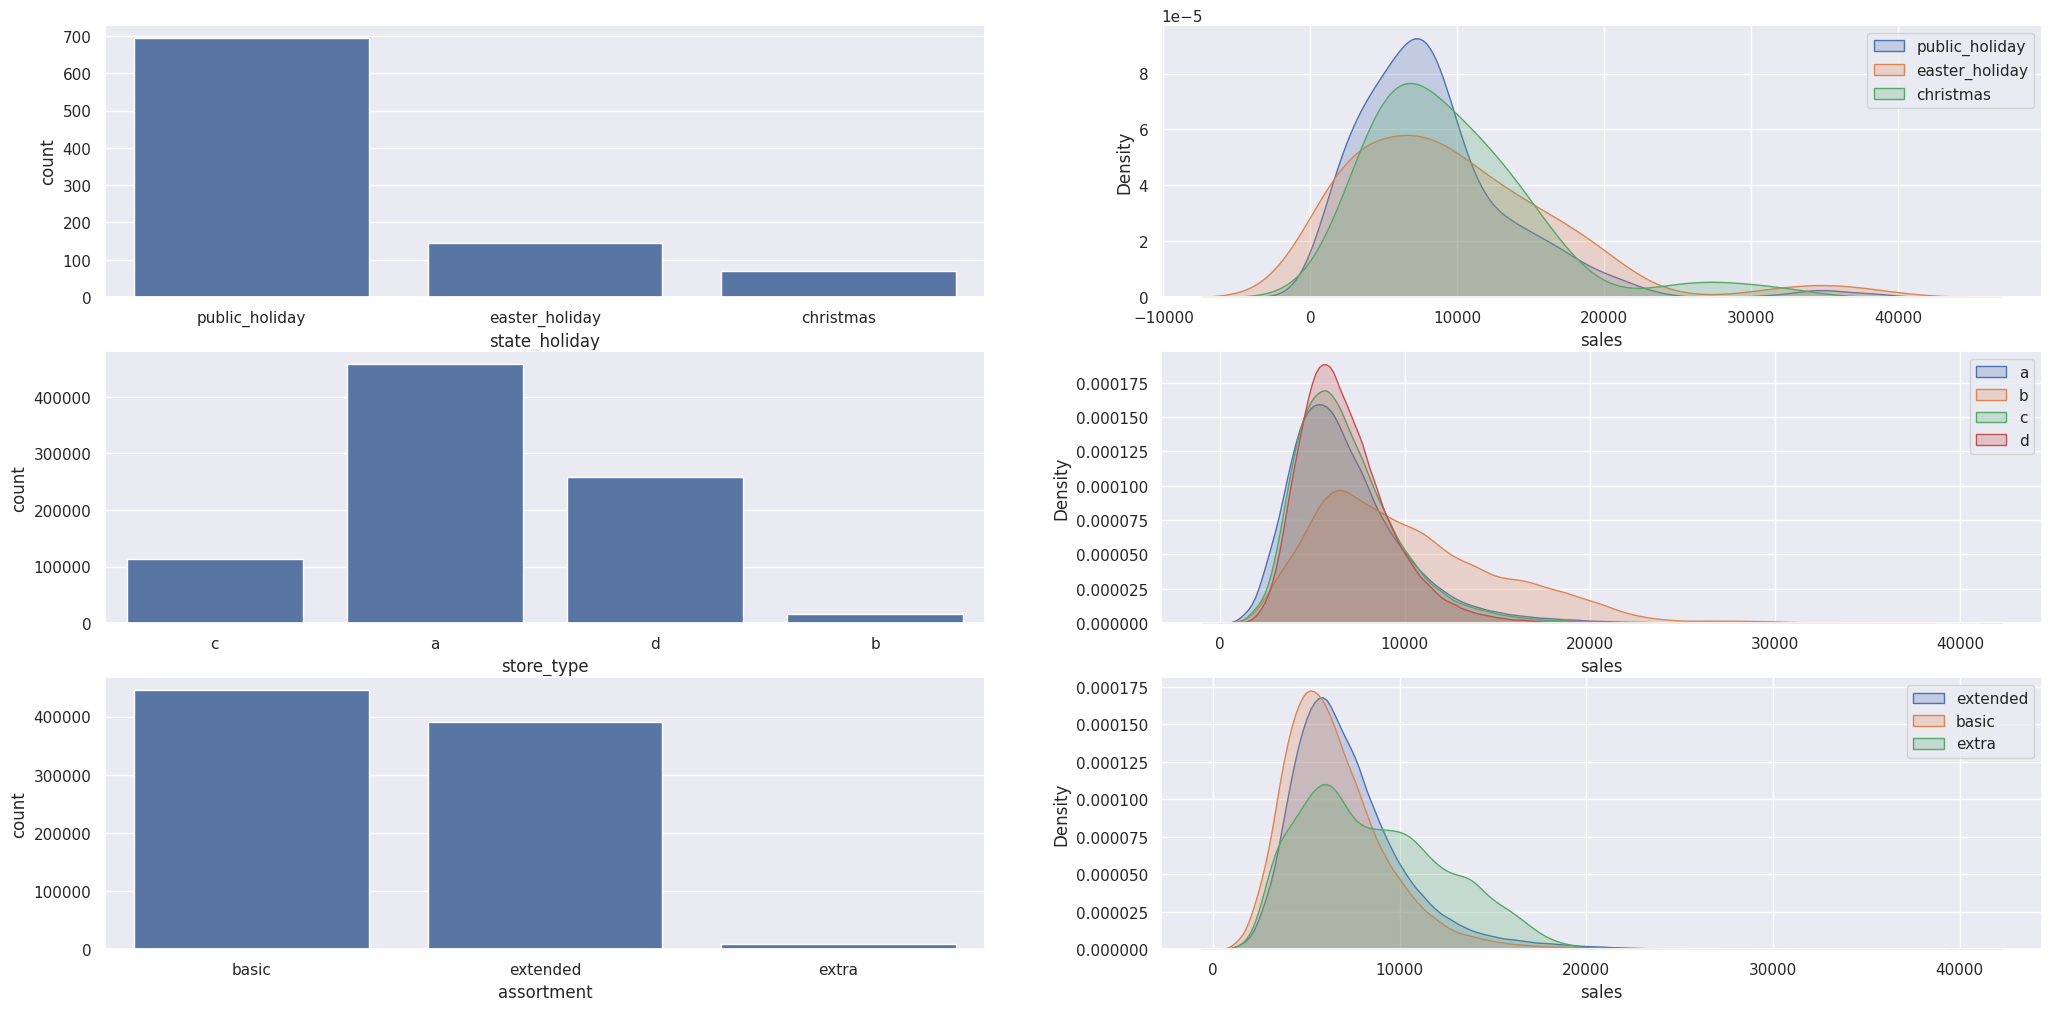

In [40]:
# state_holiday
plt.subplot(3, 2, 1)
df_aux = df4.loc[df4["state_holiday"] != "regular_day"]
sns.countplot(x=df_aux["state_holiday"])

plt.subplot(3, 2, 2)
sns.kdeplot(
    df4[df4["state_holiday"] == "public_holiday"]["sales"],
    label="public_holiday",
    fill=True,
).legend(loc="upper right")
sns.kdeplot(
    df4[df4["state_holiday"] == "easter_holiday"]["sales"],
    label="easter_holiday",
    fill=True,
).legend(loc="upper right")
sns.kdeplot(
    df4[df4["state_holiday"] == "christmas"]["sales"], label="christmas", fill=True
).legend(loc="upper right")

# store_type
plt.subplot(3, 2, 3)
sns.countplot(x=df4["store_type"])

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4["store_type"] == "a"]["sales"], label="a", fill=True).legend(
    loc="upper right"
)
sns.kdeplot(df4[df4["store_type"] == "b"]["sales"], label="b", fill=True).legend(
    loc="upper right"
)
sns.kdeplot(df4[df4["store_type"] == "c"]["sales"], label="c", fill=True).legend(
    loc="upper right"
)
sns.kdeplot(df4[df4["store_type"] == "d"]["sales"], label="d", fill=True).legend(
    loc="upper right"
)

# assortment
plt.subplot(3, 2, 5)
sns.countplot(x=df4["assortment"])

plt.subplot(3, 2, 6)
sns.kdeplot(
    df4[df4["assortment"] == "extended"]["sales"], label="extended", fill=True
).legend(loc="upper right")
sns.kdeplot(
    df4[df4["assortment"] == "basic"]["sales"], label="basic", fill=True
).legend(loc="upper right")
sns.kdeplot(
    df4[df4["assortment"] == "extra"]["sales"], label="extra", fill=True
).legend(loc="upper right")

## 4.2 - Bivariate Analysis

### **H1.** Stores with higher assortment should sell more.  
**TRUE:** Stores with **higher assortment**, on average, sell **more**.

<Axes: xlabel='year_week'>

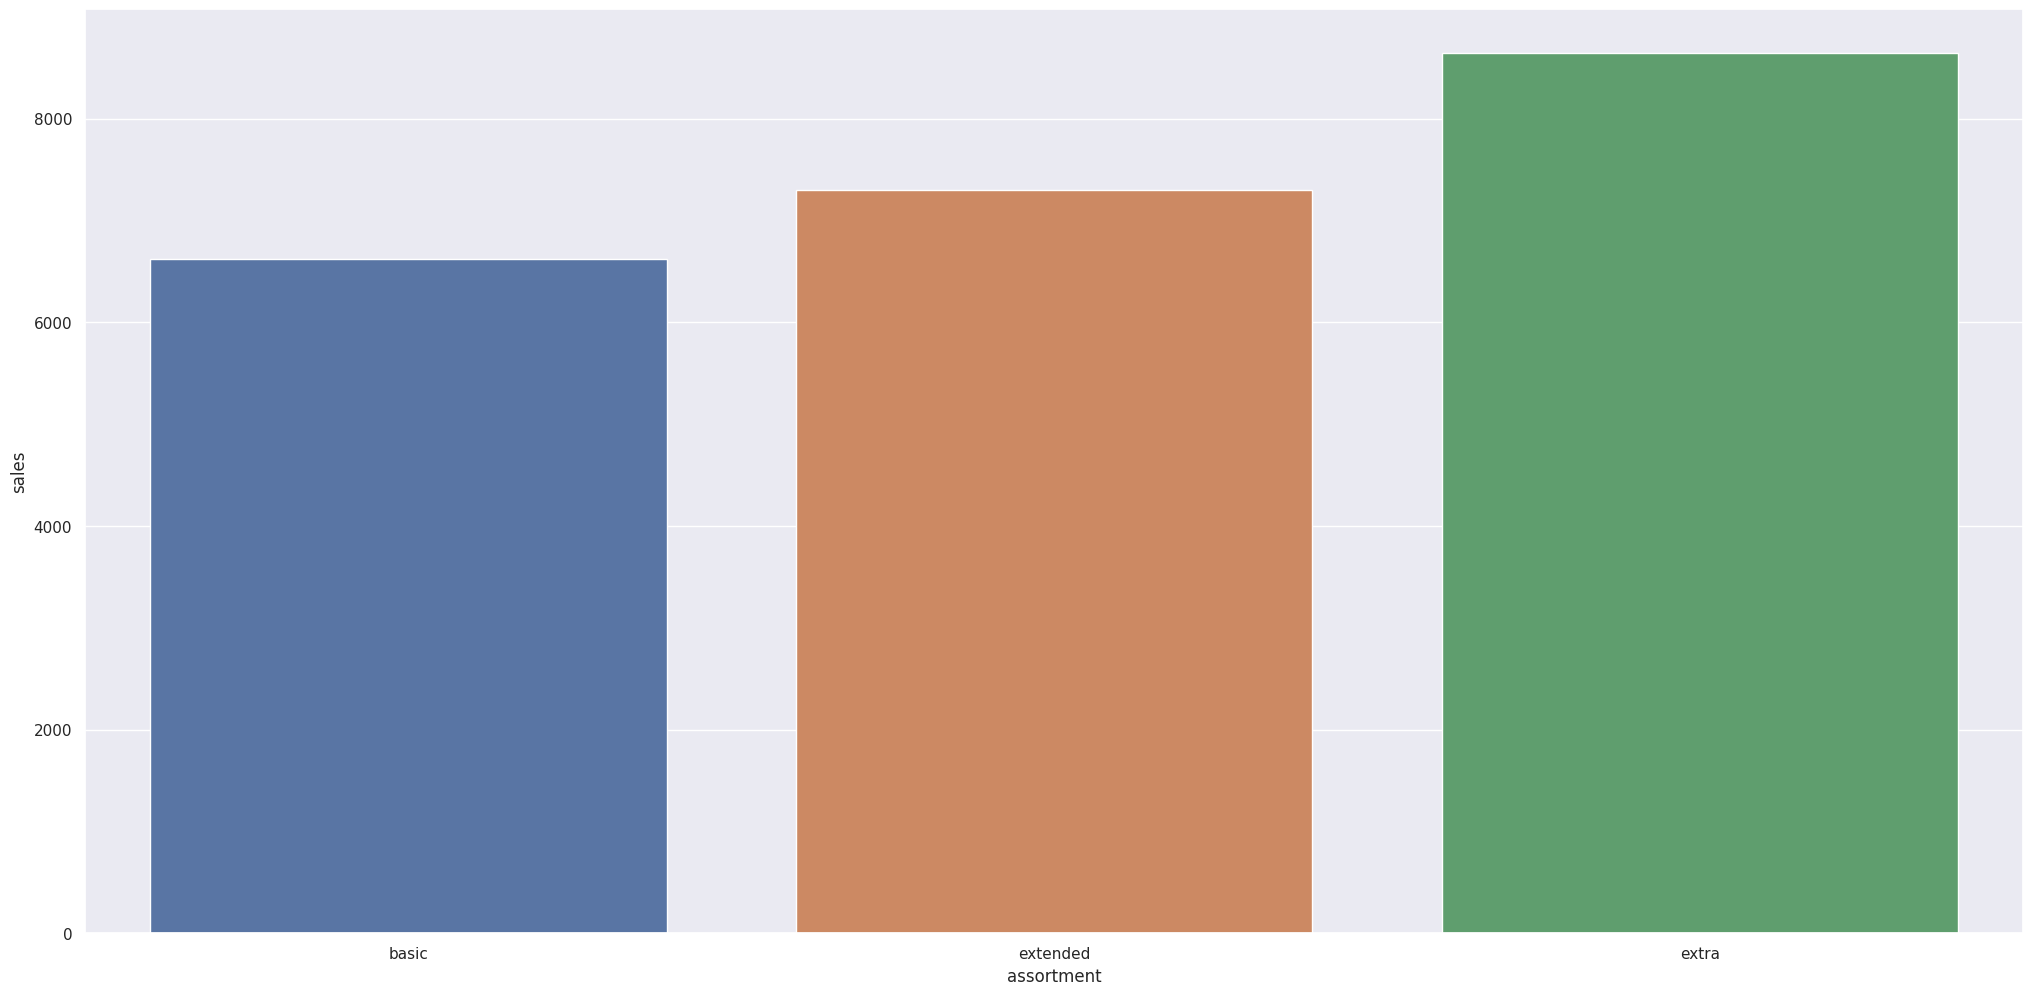

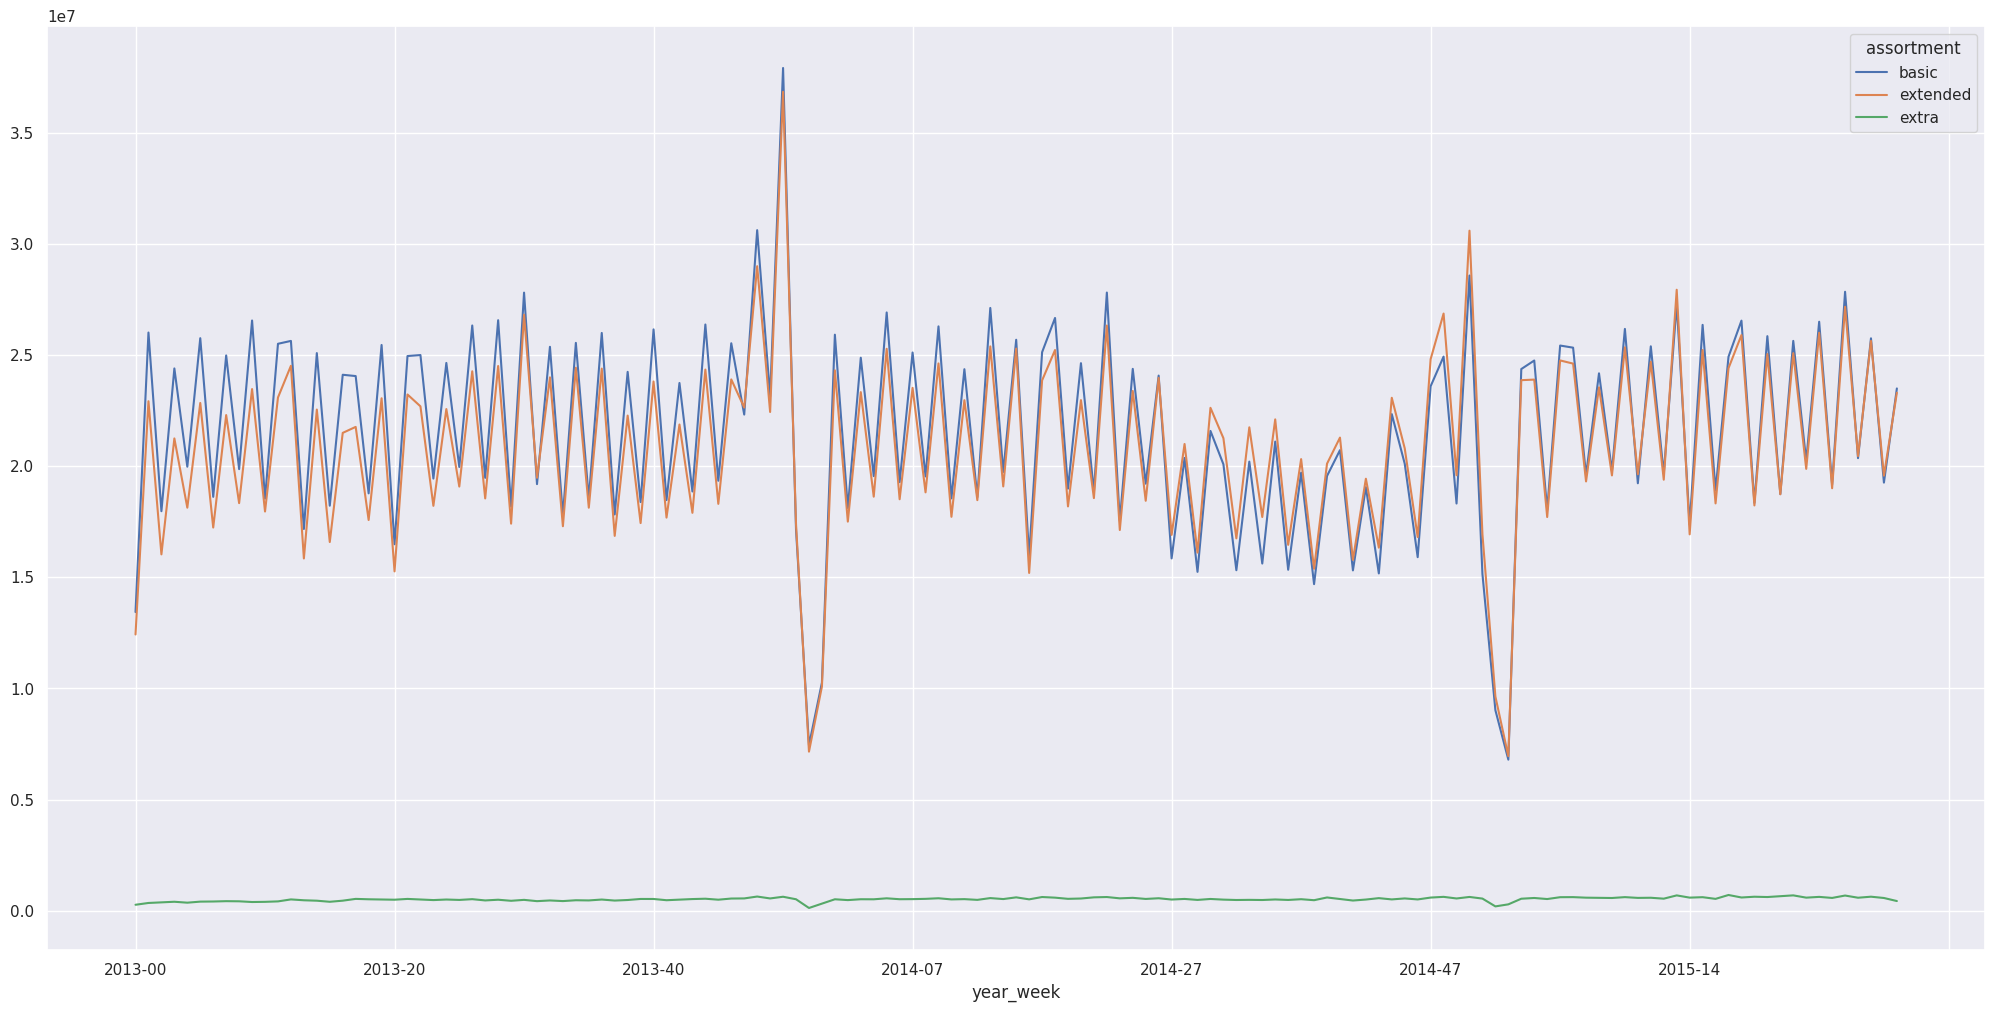

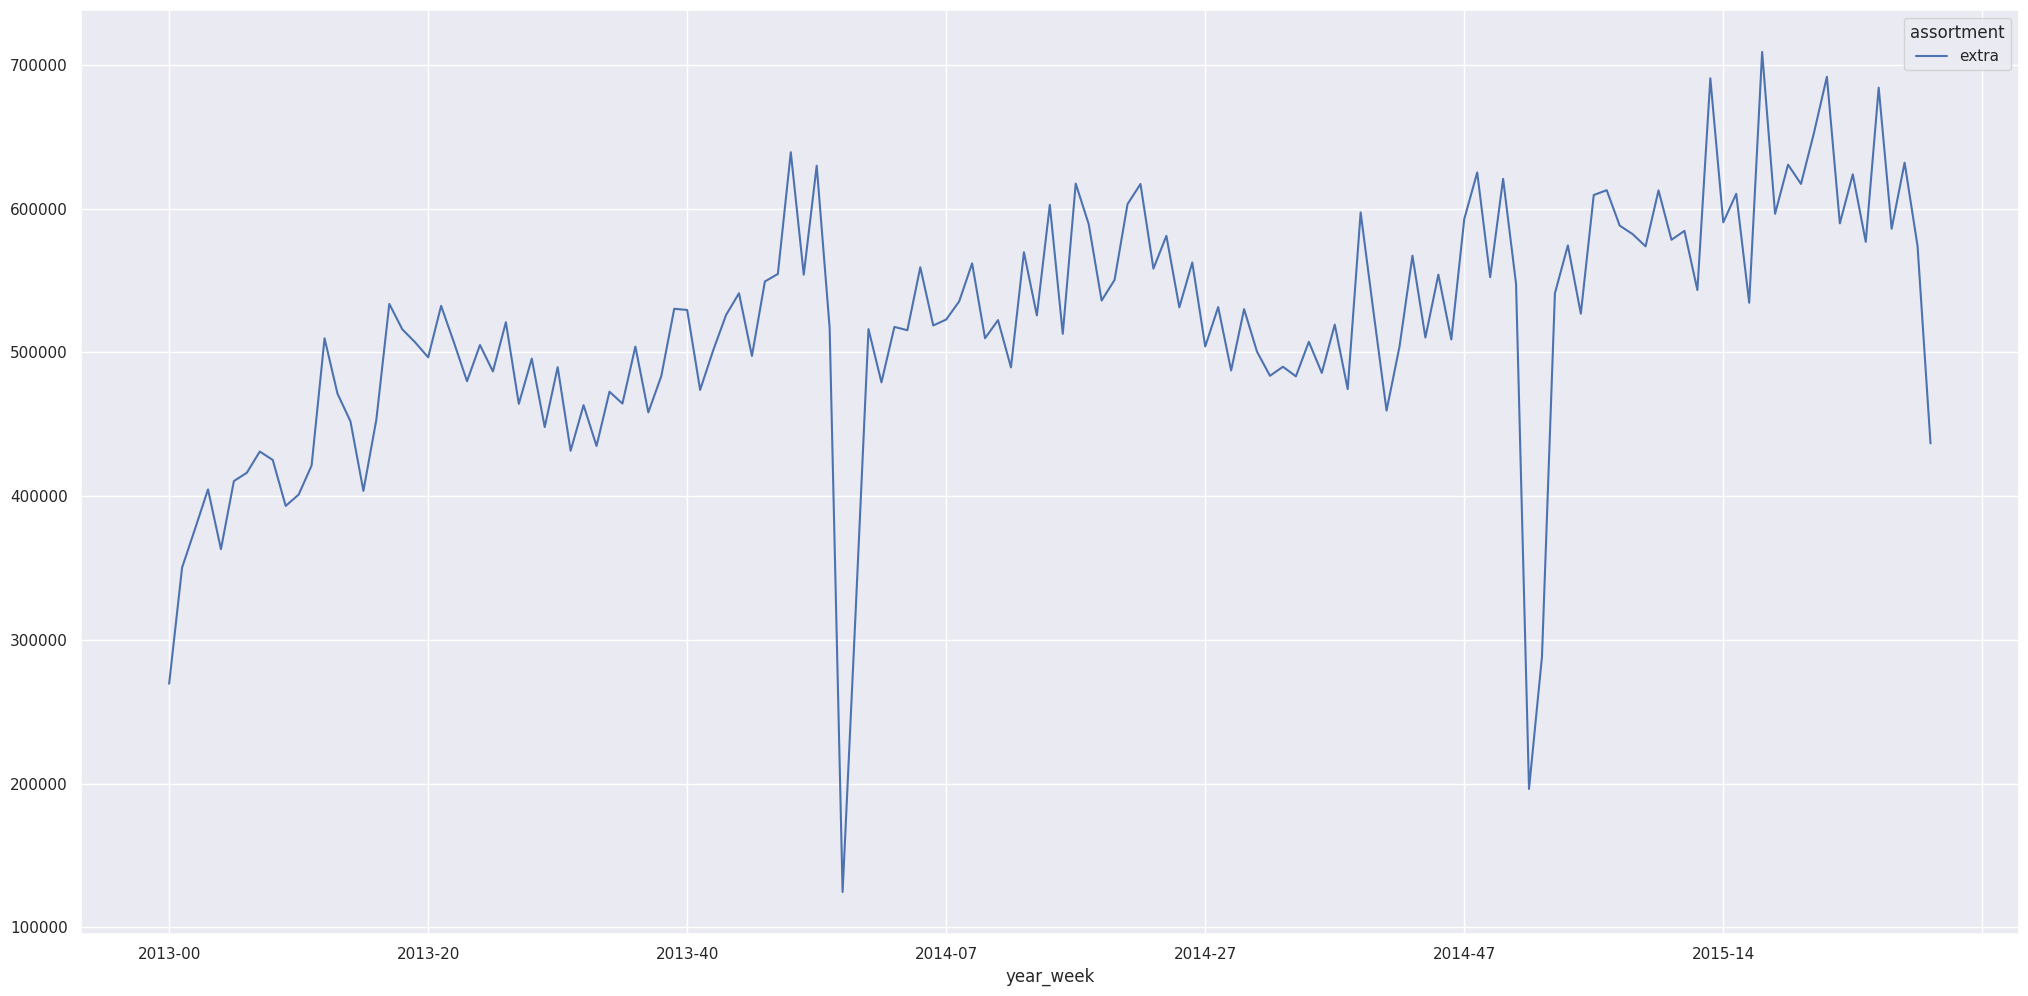

In [41]:
aux1 = df4.loc[:, ["assortment", "sales"]].groupby(["assortment"]).mean().reset_index()
sns.barplot(x="assortment", y="sales", data=aux1, hue="assortment")

aux2 = (
    df4.loc[:, ["year_week", "assortment", "sales"]]
    .groupby(["year_week", "assortment"])
    .sum()
    .reset_index()
)
aux2.pivot(index="year_week", columns="assortment", values="sales").plot()

aux3 = aux2.loc[aux2["assortment"] == "extra", :]
aux3.pivot(index="year_week", columns="assortment", values="sales").plot()

### **H2.** Store with close competitores should sell less.  
**FALSE:** Theres **no clear correlation** between competition distance and sales.

<Axes: >

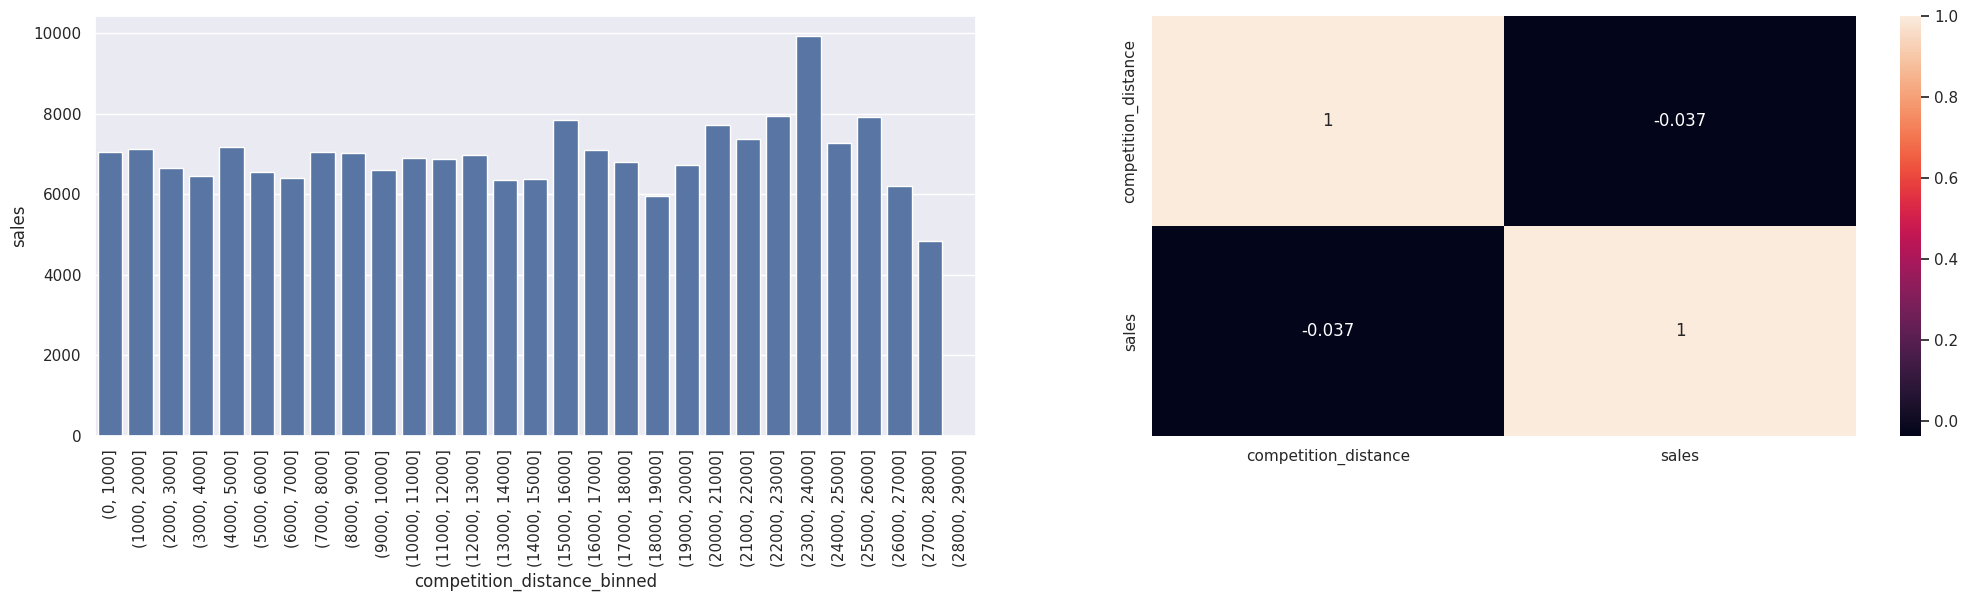

In [42]:
aux1 = (
    df4.loc[:, ["competition_distance", "sales"]]
    .groupby(["competition_distance"])
    .mean()
    .reset_index()
)

bins = list(np.arange(0, 30000, 1000))
aux2 = aux1.copy()
aux2["competition_distance_binned"] = pd.cut(aux1["competition_distance"], bins=bins)
aux3 = (
    aux2.loc[:, ["competition_distance_binned", "sales"]]
    .groupby(["competition_distance_binned"])
    .mean()
    .reset_index()
)

plt.subplot(2, 2, 1)
sns.barplot(x="competition_distance_binned", y="sales", data=aux3)
plt.xticks(rotation=90)

plt.subplot(2, 2, 2)
sns.heatmap(aux1.corr(method="pearson"), annot=True)

### **H3.** Stores with older competitors should sell more.  
**FALSE:** Theres **no clear correlation** between competitors age and sales.

<Axes: >

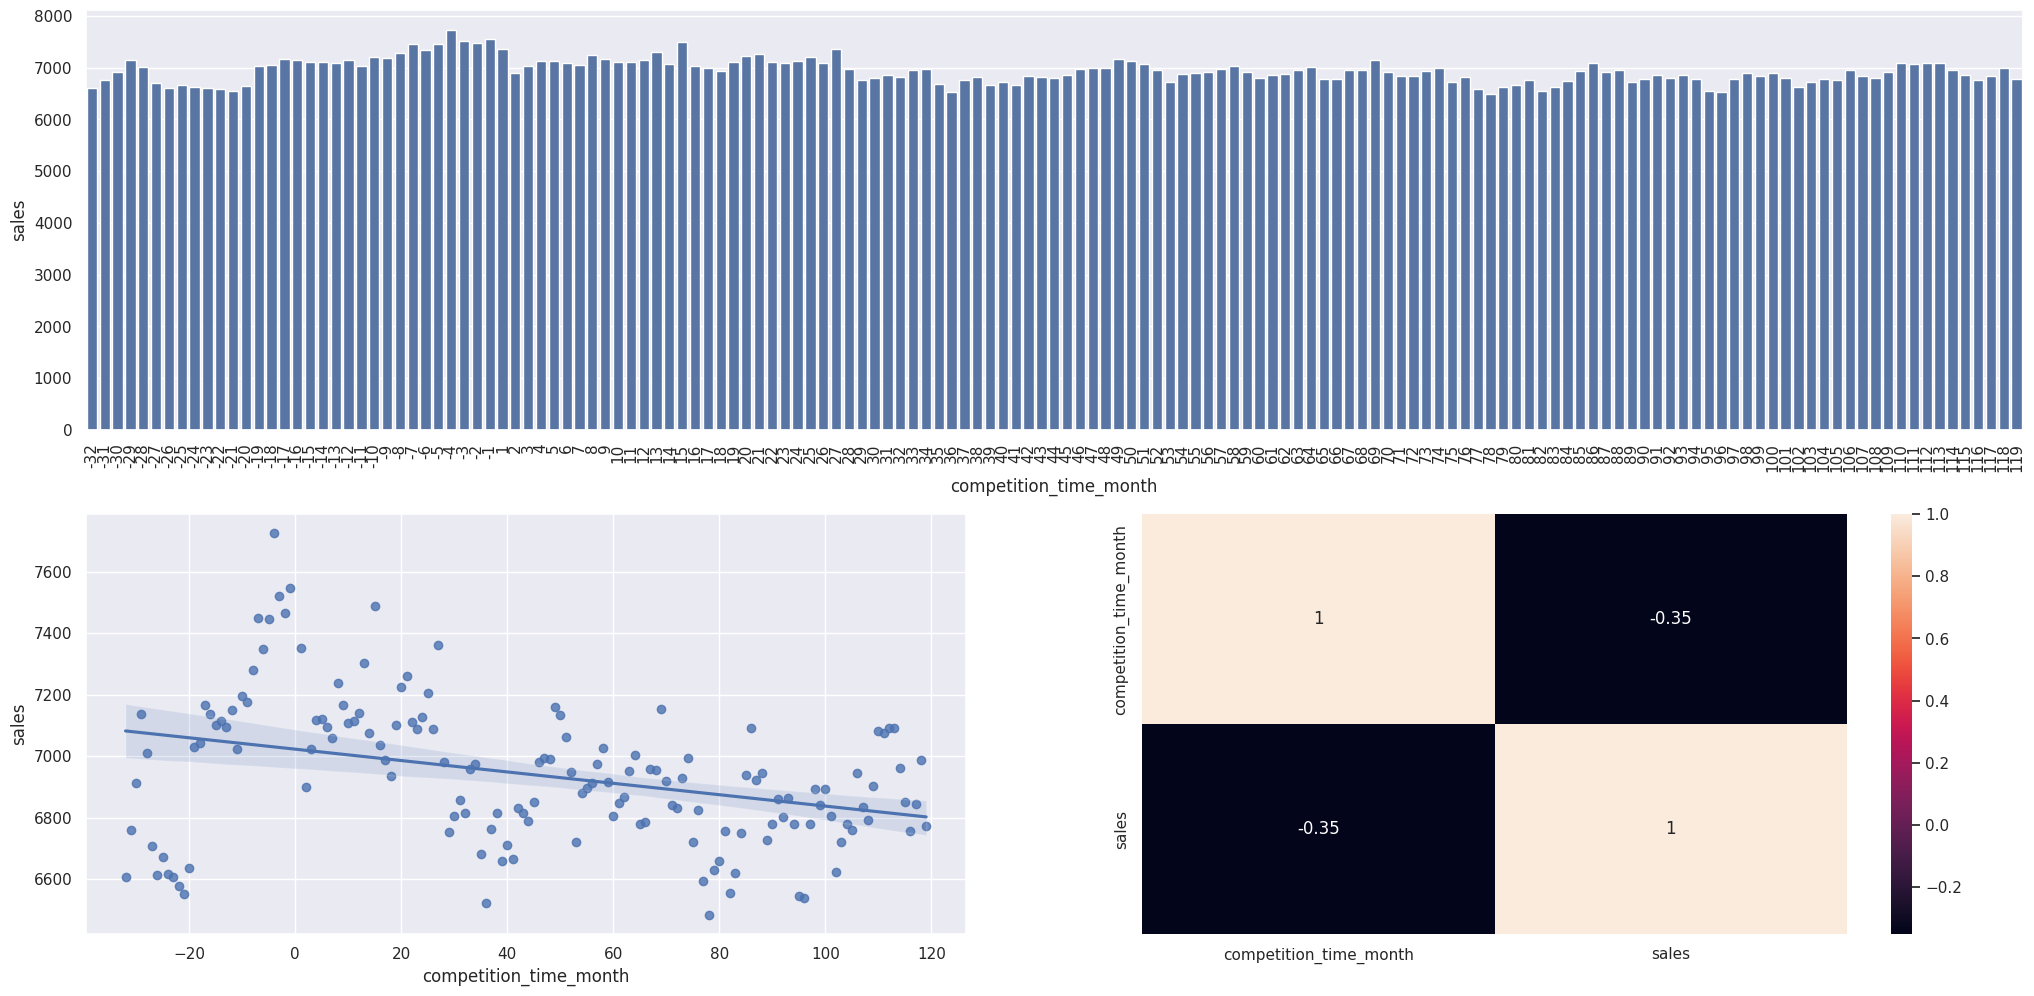

In [43]:
aux1 = (
    df4.loc[:, ["competition_time_month", "sales"]]
    .groupby(["competition_time_month"])
    .mean()
    .reset_index()
)

aux2 = aux1.loc[
    (aux1["competition_time_month"] < 120) & (aux1["competition_time_month"] != 0), :
]

grid = GridSpec(2, 2)

plt.subplot(grid[0, :])
sns.barplot(x="competition_time_month", y="sales", data=aux2)
plt.xticks(rotation=90)

plt.subplot(grid[1, 0])
sns.regplot(x="competition_time_month", y="sales", data=aux2)

plt.subplot(grid[1, 1])
sns.heatmap(aux2.corr(method="pearson"), annot=True)

### **H4.** Stores with longer active promotions should sell more.  
**FALSE:** Theres **no clear correlation** between promotions active time and sales.

<Axes: >

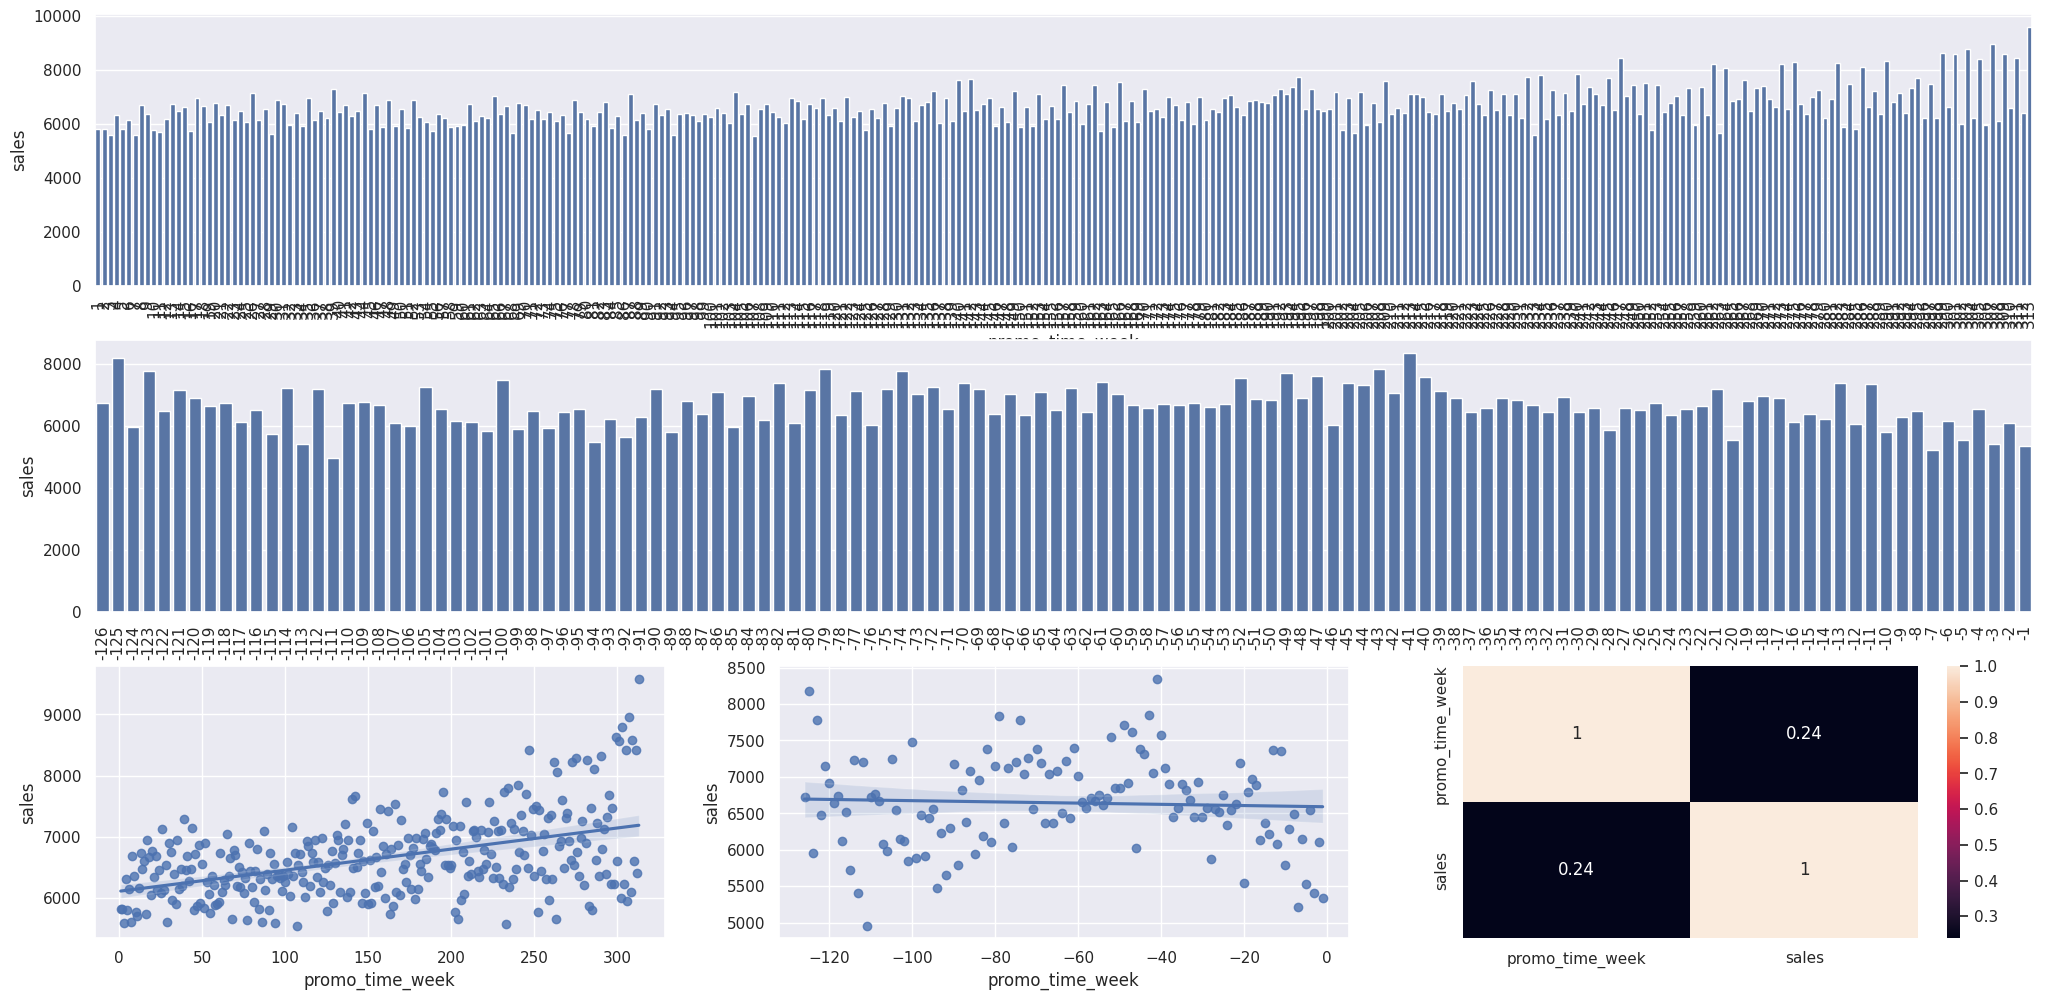

In [44]:
aux1 = (
    df4.loc[:, ["promo_time_week", "sales"]]
    .groupby(["promo_time_week"])
    .mean()
    .reset_index()
)

grid = GridSpec(3, 3)

plt.subplot(grid[0, :])
aux2 = aux1.loc[aux1["promo_time_week"] > 0]  # promo extendido
sns.barplot(x="promo_time_week", y="sales", data=aux2)
plt.xticks(rotation=90)

plt.subplot(grid[1, :])
aux3 = aux1.loc[aux1["promo_time_week"] < 0]  # promo regular
sns.barplot(x="promo_time_week", y="sales", data=aux3)
plt.xticks(rotation=90)

plt.subplot(grid[2, 0])
sns.regplot(x="promo_time_week", y="sales", data=aux2)

plt.subplot(grid[2, 1])
sns.regplot(x="promo_time_week", y="sales", data=aux3)

plt.subplot(grid[2, 2])
sns.heatmap(aux1.corr(method="pearson"), annot=True)

### **H5.** Stores with more promotion days should sell more.  

### **H6.** Stores with more consecutive promotions should sell more.  
**FALSE:** Stores with **consecutive promotions**, on average, sell **less**.  

In [45]:
df4.loc[:, ["promo", "promo2", "sales"]].groupby(
    ["promo", "promo2"]
).mean().reset_index()

,promo,promo2,sales
0,0,0,6328.187633
1,0,1,5529.566684
2,1,0,8618.452062
3,1,1,7836.672987


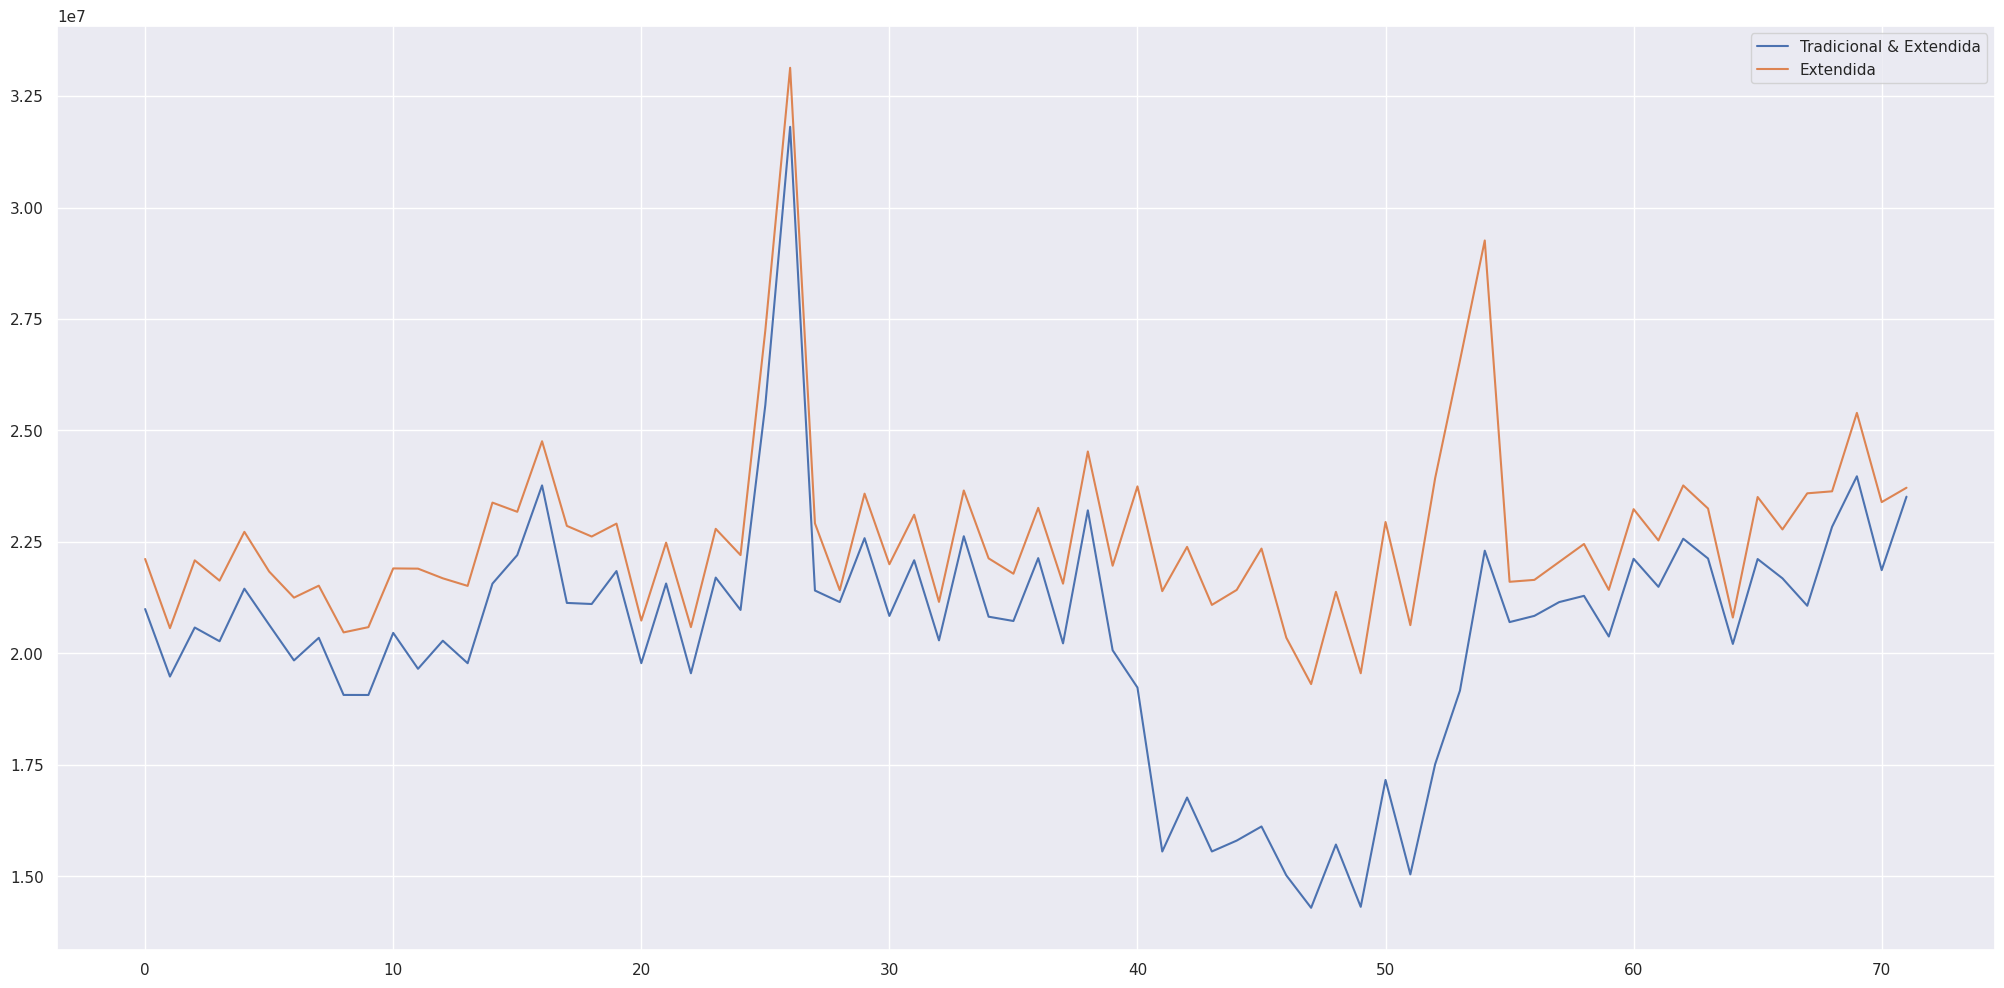

In [46]:
aux1 = (
    df4.loc[(df4["promo"] == 1) & (df4["promo2"] == 1), ["year_week", "sales"]]
    .groupby(["year_week"])
    .sum()
    .reset_index()
)
ax = aux1.plot()

aux2 = (
    df4.loc[(df4["promo"] == 1) & (df4["promo2"] == 0), ["year_week", "sales"]]
    .groupby(["year_week"])
    .sum()
    .reset_index()
)
aux2.plot(ax=ax)
ax.legend(labels=["Tradicional & Extendida", "Extendida"])

### **H7.** Stores should sell more on christmas.  
**TRUE:** Stores sell **more during christmas** than regular days, on average.  

<Axes: xlabel='year', ylabel='sales'>

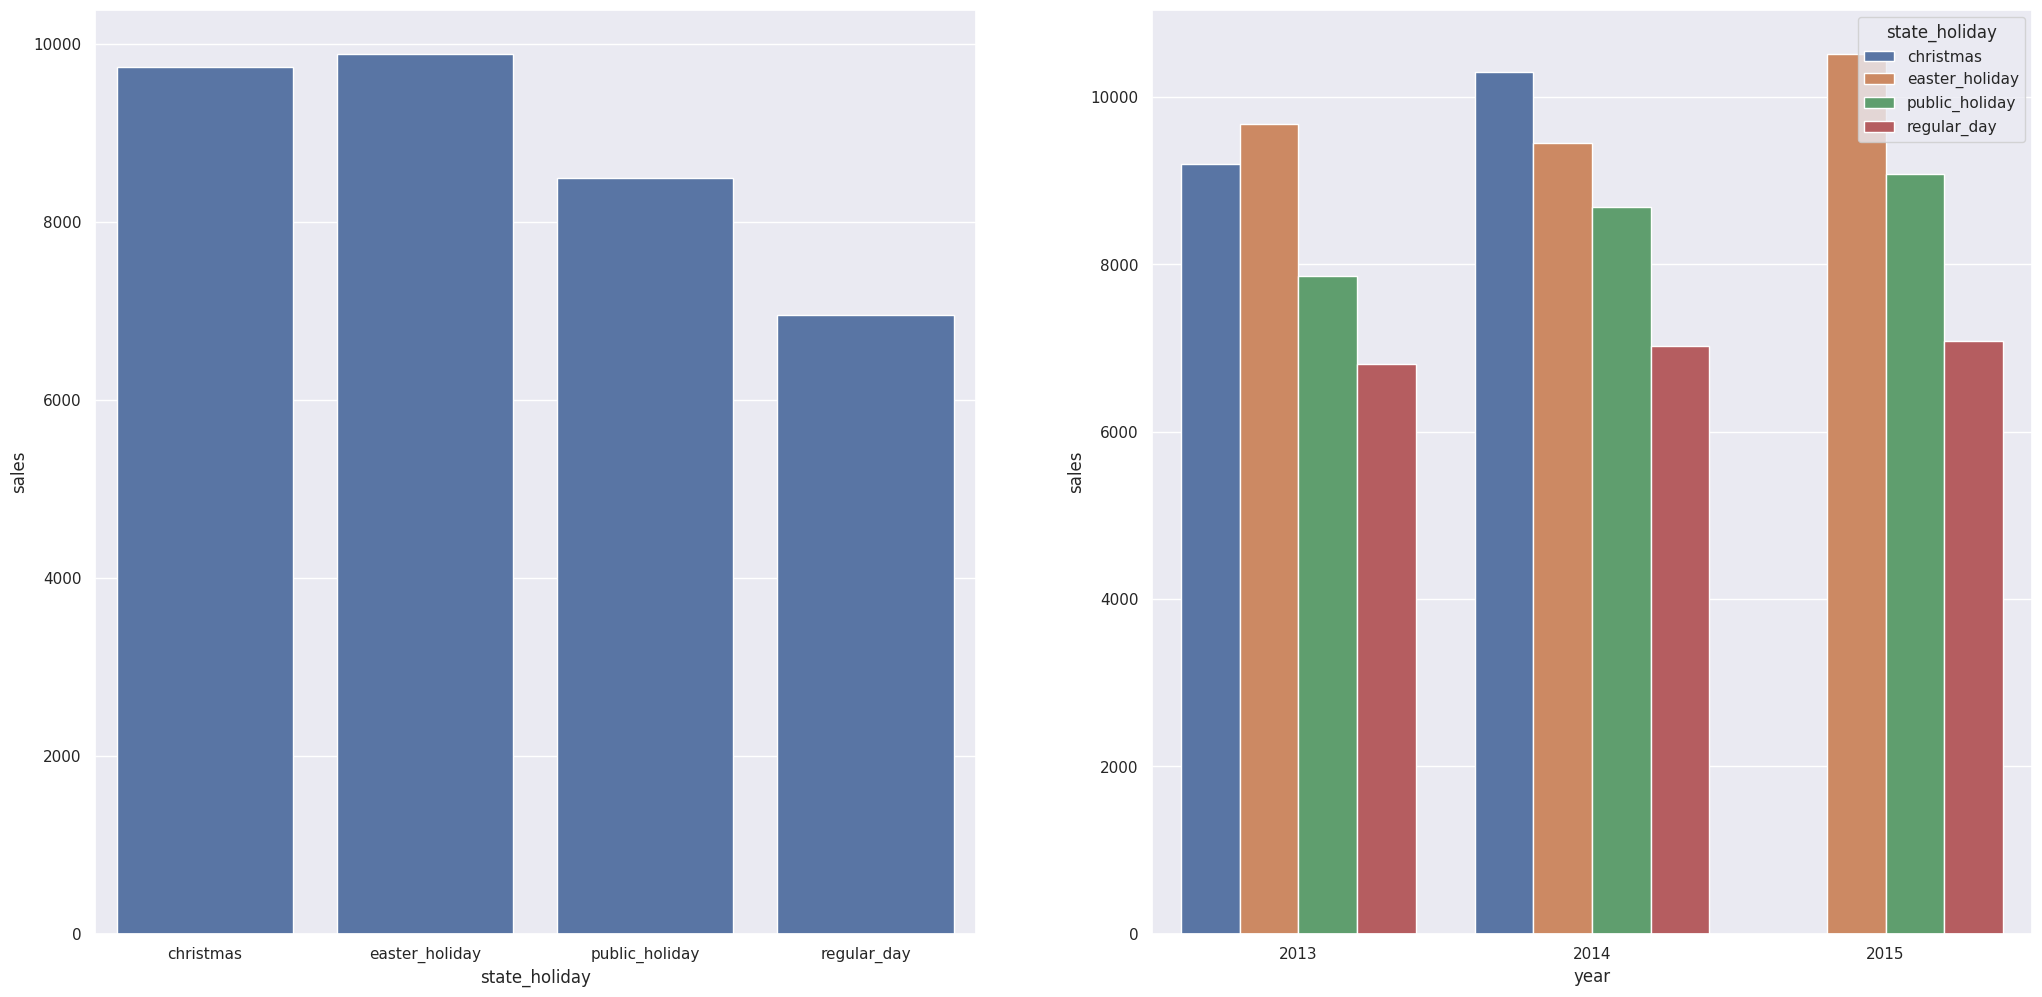

In [47]:
aux1 = (
    df4.loc[:, ["state_holiday", "sales"]]
    .groupby(["state_holiday"])
    .mean()
    .reset_index()
)
plt.subplot(1, 2, 1)
sns.barplot(x="state_holiday", y="sales", data=aux1)

plt.subplot(1, 2, 2)
aux2 = (
    df4.loc[:, ["year", "state_holiday", "sales"]]
    .groupby(["year", "state_holiday"])
    .mean()
    .reset_index()
)
sns.barplot(x="year", y="sales", hue="state_holiday", data=aux2)

### **H8.** Stores should sell more throughout the years.  
**FALSE:** There is **no clear growth trend** in sales through the years. But there is a seasonality trend.

([<matplotlib.axis.XTick at 0x7fd8c2865480>,
 [Text(15706.0, 0, '2013-01-01'),
  Text(15737.0, 0, '2013-02-01'),
  Text(15765.0, 0, '2013-03-01'),
  Text(15796.0, 0, '2013-04-01'),
  Text(15826.0, 0, '2013-05-01'),
  Text(15857.0, 0, '2013-06-01'),
  Text(15887.0, 0, '2013-07-01'),
  Text(15918.0, 0, '2013-08-01'),
  Text(15949.0, 0, '2013-09-01'),
  Text(15979.0, 0, '2013-10-01'),
  Text(16010.0, 0, '2013-11-01'),
  Text(16040.0, 0, '2013-12-01'),
  Text(16071.0, 0, '2014-01-01'),
  Text(16102.0, 0, '2014-02-01'),
  Text(16130.0, 0, '2014-03-01'),
  Text(16161.0, 0, '2014-04-01'),
  Text(16191.0, 0, '2014-05-01'),
  Text(16222.0, 0, '2014-06-01'),
  Text(16252.0, 0, '2014-07-01'),
  Text(16283.0, 0, '2014-08-01'),
  Text(16314.0, 0, '2014-09-01'),
  Text(16344.0, 0, '2014-10-01'),
  Text(16375.0, 0, '2014-11-01'),
  Text(16405.0, 0, '2014-12-01'),
  Text(16436.0, 0, '2015-01-01'),
  Text(16467.0, 0, '2015-02-01'),
  Text(16495.0, 0, '2015-03-01'),
  Text(16526.0, 0, '2015-04-01'),
  T

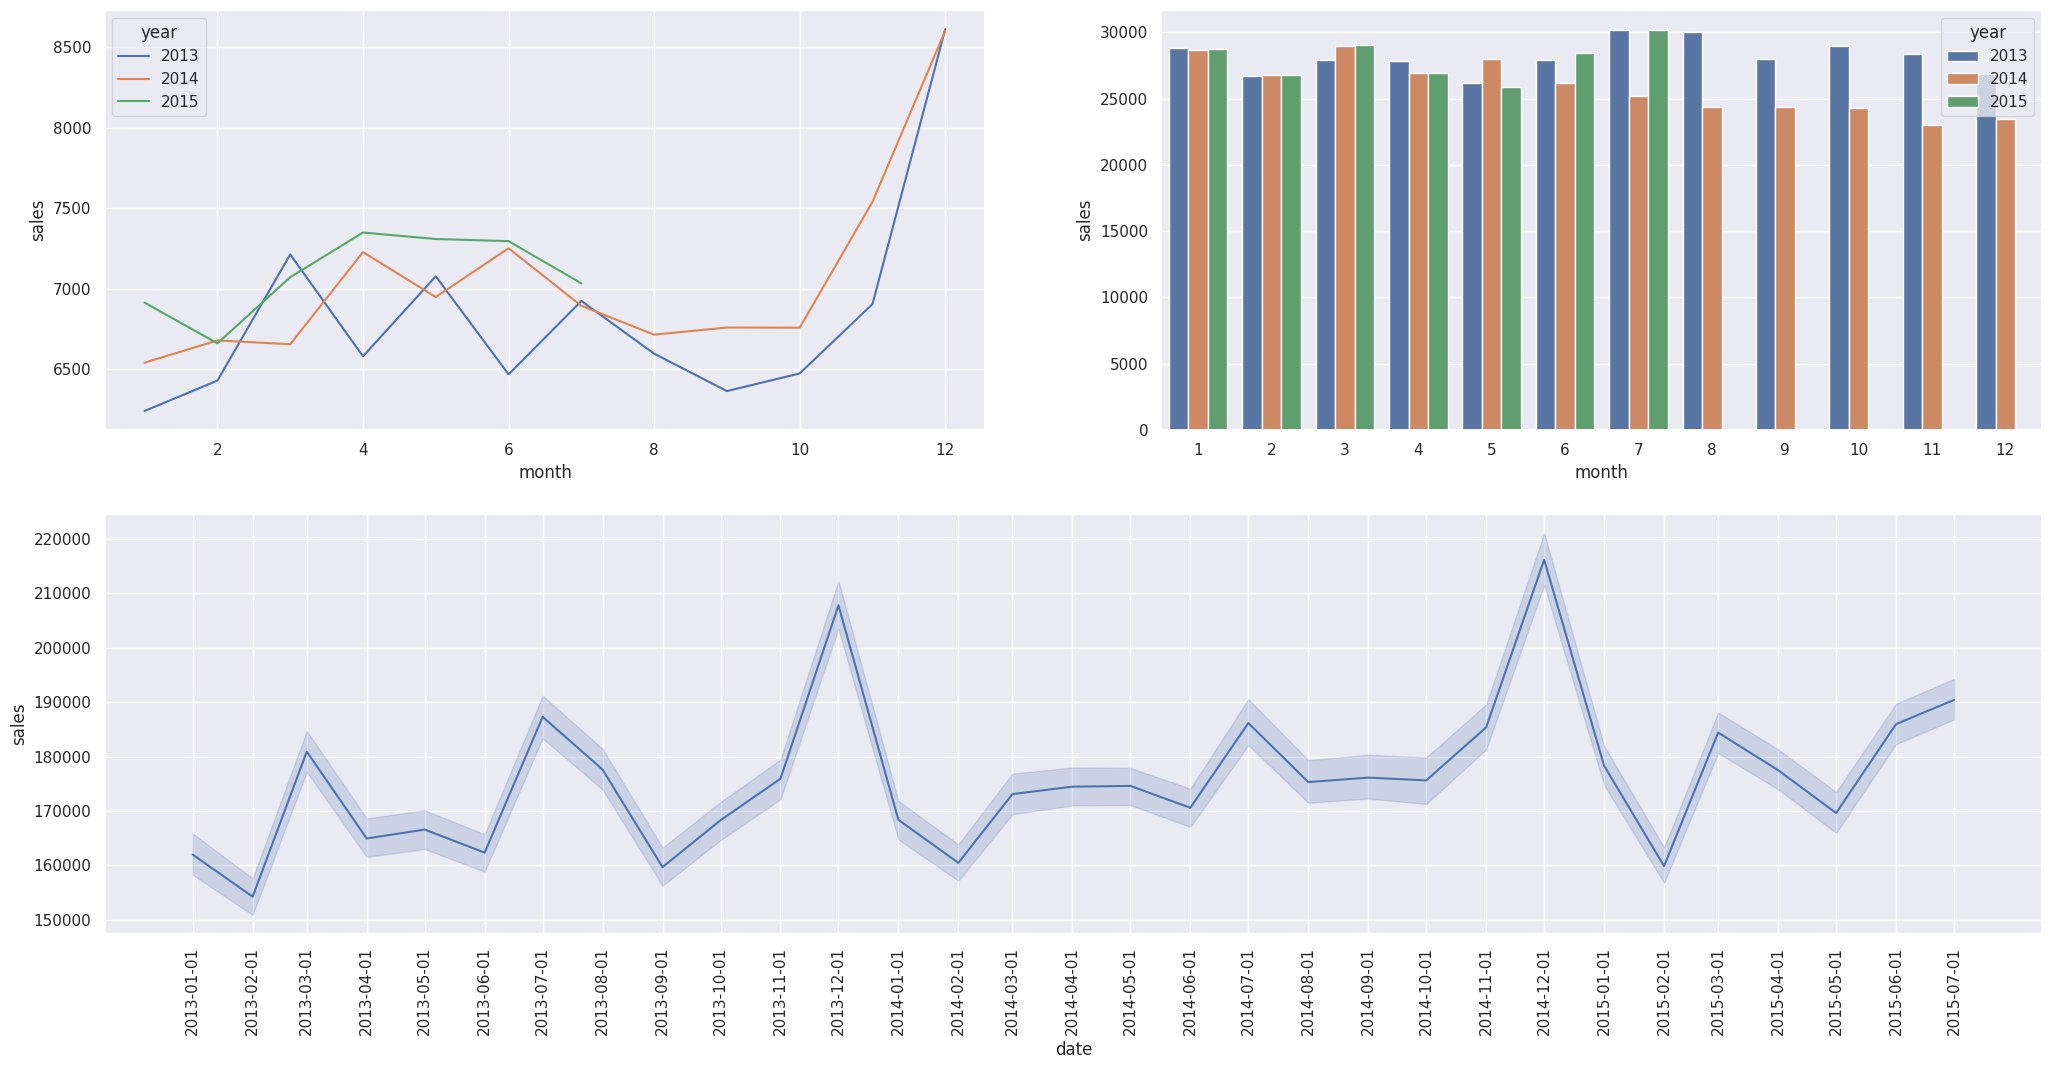

In [48]:
aux1 = (
    df4.loc[:, ["year", "month", "sales"]]
    .groupby(["year", "month"])
    .mean()
    .reset_index()
)
aux1["year"] = aux1["year"].astype(str)

aux2 = (
    df4.loc[:, ["year", "month", "sales"]]
    .groupby(["year", "month"])
    .count()
    .reset_index()
)
aux2["year"] = aux2["year"].astype(str)

aux3 = (
    df4.loc[:, ["store", "year", "month", "sales"]]
    .groupby(["store", "year", "month"])
    .sum()
    .reset_index()
)

aux3["date"] = pd.to_datetime(aux3[["year", "month"]].assign(DAY=1))
aux3 = aux3.drop(["year", "month"], axis=1)

grid = GridSpec(2, 2)

plt.subplot(grid[0, 0])
sns.lineplot(data=aux1, x="month", y="sales", hue="year")

plt.subplot(grid[0, 1])
sns.barplot(data=aux2, x="month", y="sales", hue="year")

plt.subplot(grid[1, :])
sns.lineplot(data=aux3, x="date", y="sales")
plt.xticks(ticks=aux3["date"].unique(), rotation=90)

### **H9.** Stores should sell more on the second semester.  
**TRUE:** Stores sell **more** in the second semester, specially in december.  

<Axes: xlabel='year', ylabel='sales'>

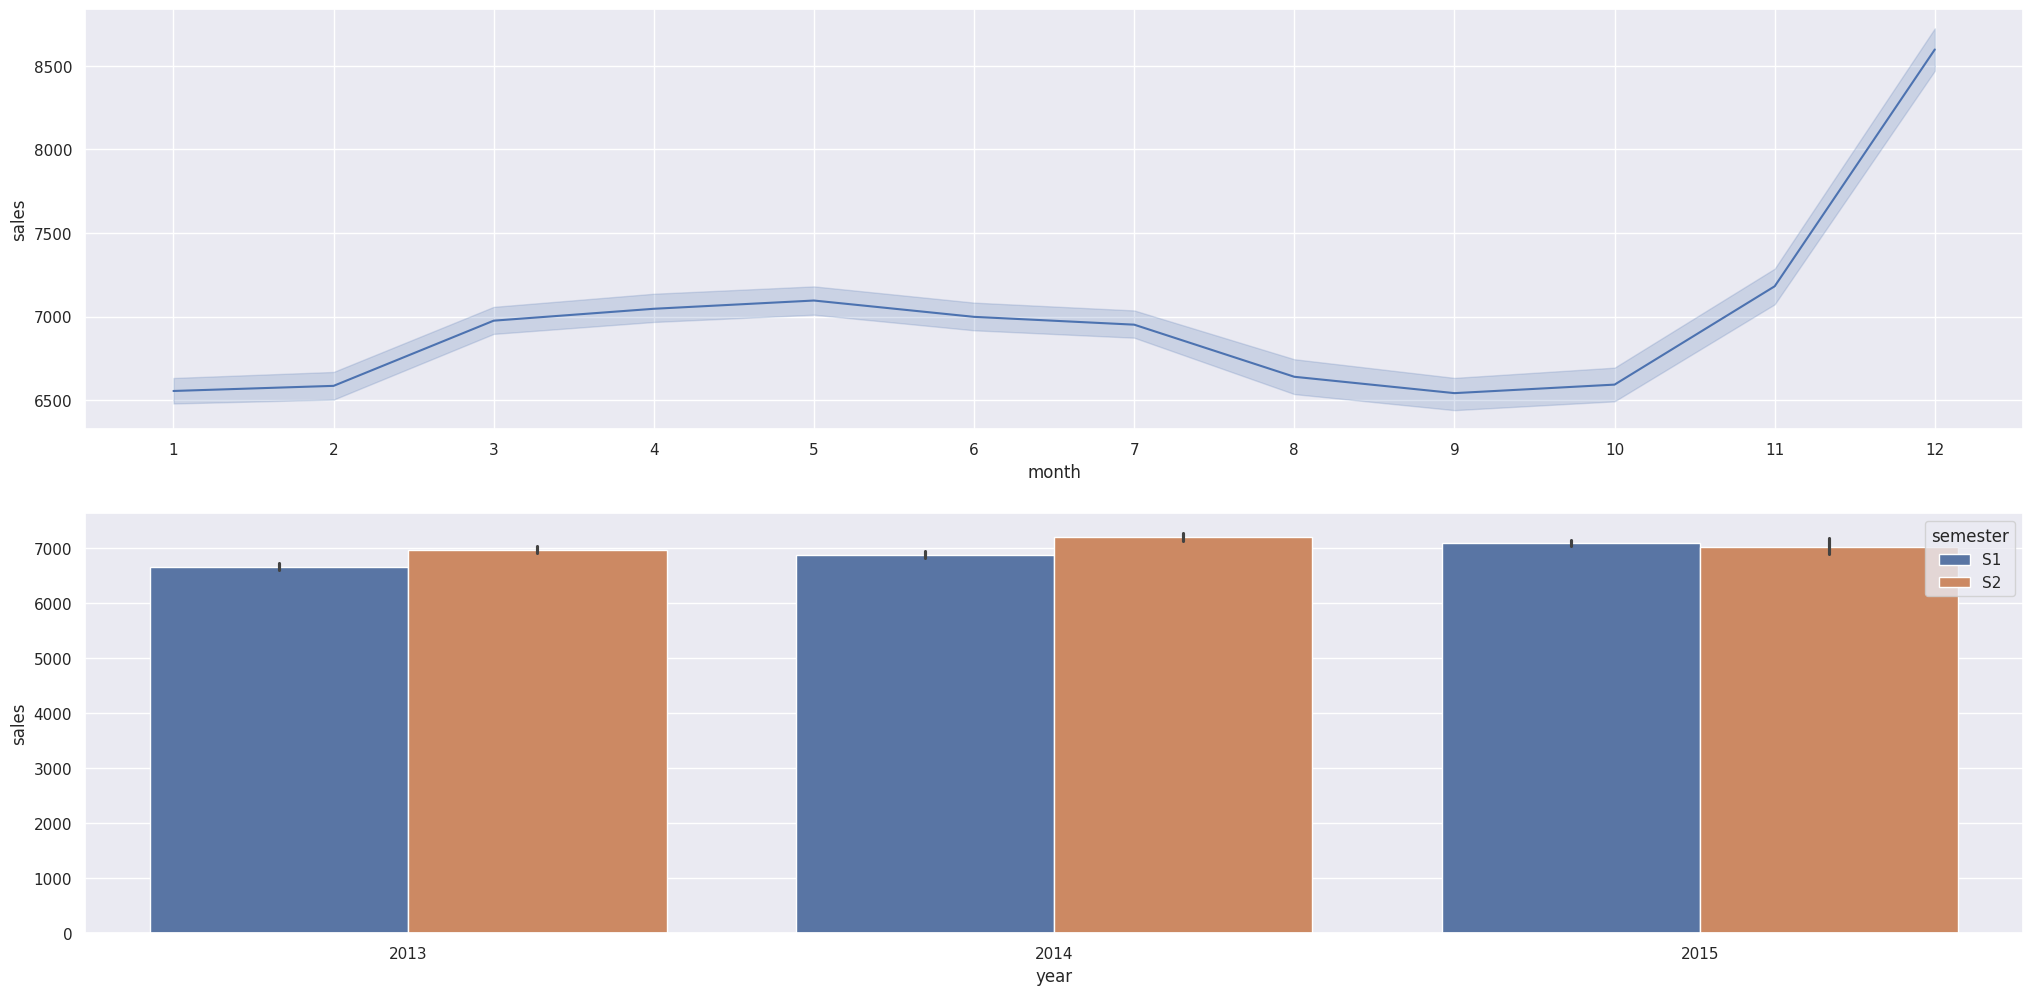

In [49]:
aux1 = (
    df4.loc[:, ["store", "year", "month", "sales"]]
    .groupby(["store", "year", "month"])
    .mean()
    .reset_index()
)

aux2 = aux1.copy()
aux2["semester"] = aux2["month"].apply(lambda x: "S1" if x <= 6 else "S2")
aux2 = aux2.drop(["month"], axis=1)

plt.subplot(2, 1, 1)
sns.lineplot(x="month", y="sales", data=aux1)
plt.xticks(ticks=aux1["month"].unique())
plt.subplot(2, 1, 2)
sns.barplot(x="year", y="sales", data=aux2, hue="semester")

### **H10.** Stores should sell more after 10th day of each month.  
**FALSE:** On average, stores **sell a regular amount** throughout the month.  

<Axes: xlabel='before_after', ylabel='sales'>

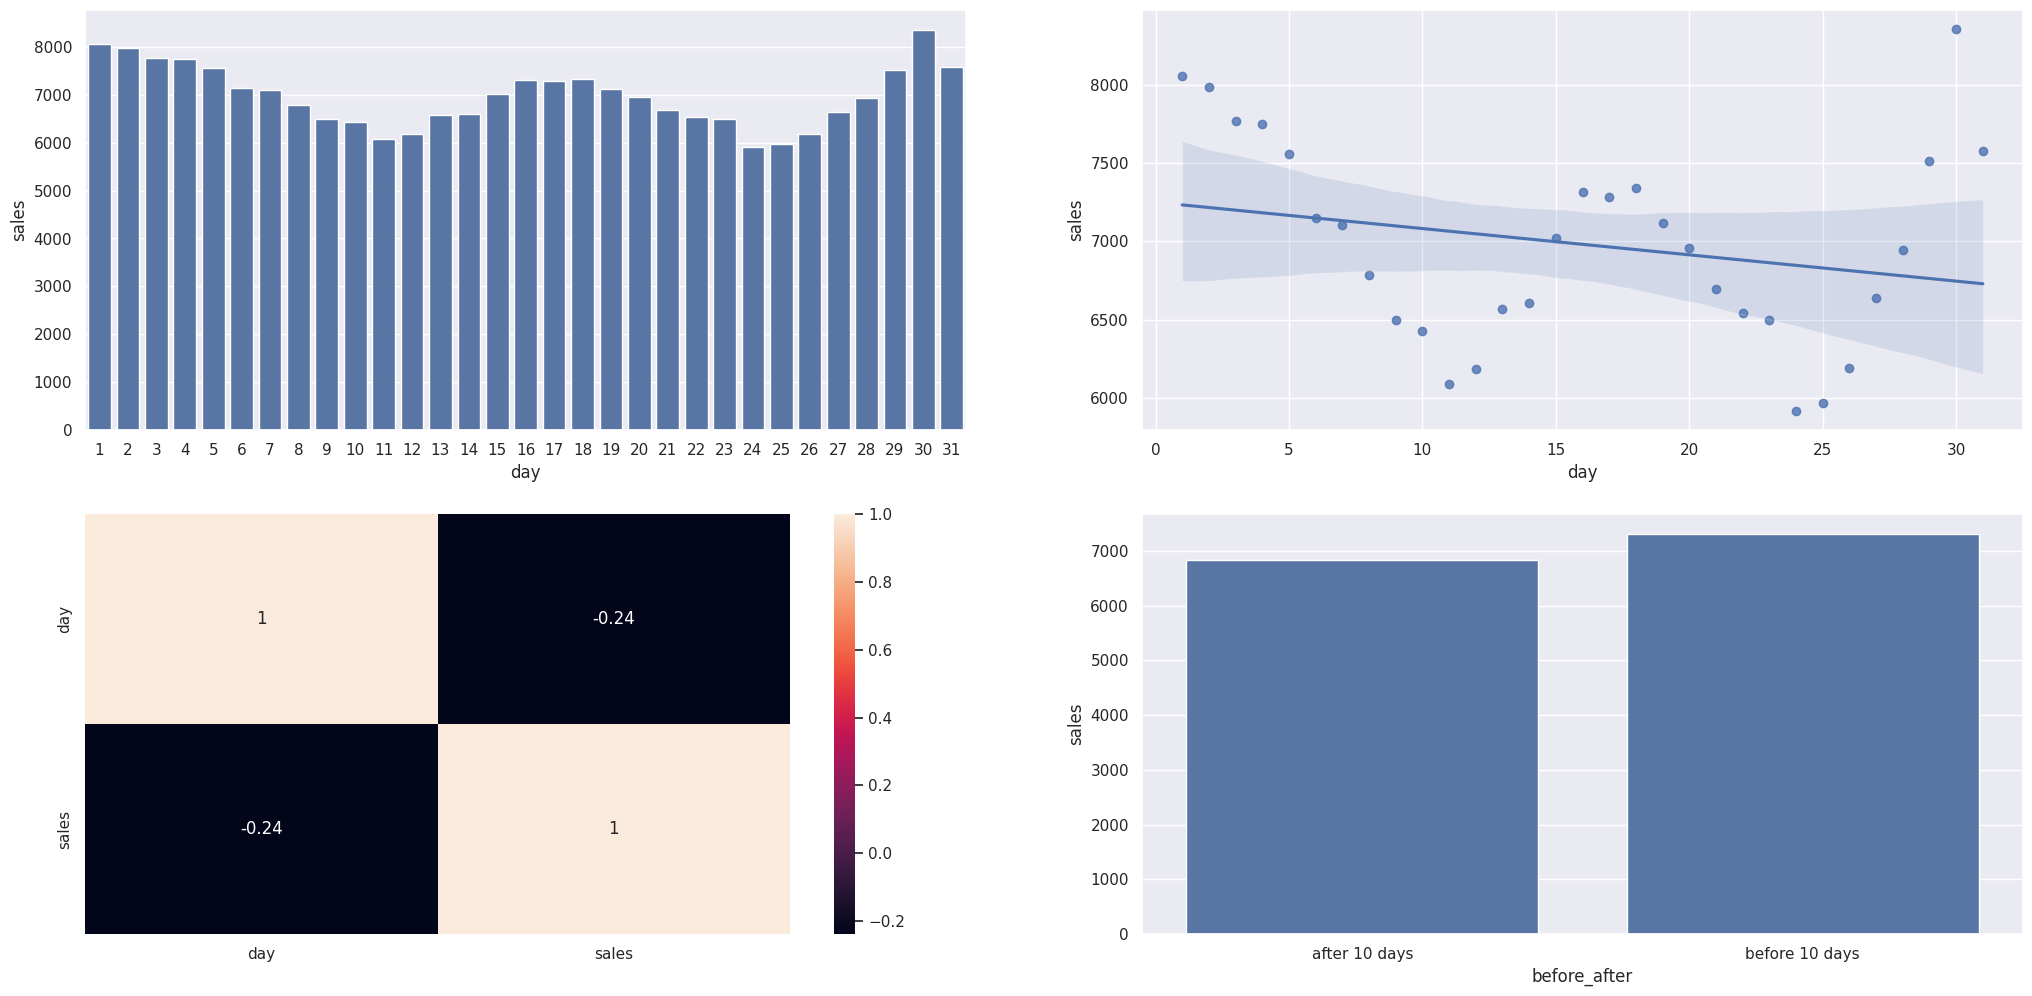

In [50]:
aux1 = df4.loc[:, ["day", "sales"]].groupby(["day"]).mean().reset_index()

plt.subplot(2, 2, 1)
sns.barplot(x="day", y="sales", data=aux1)

plt.subplot(2, 2, 2)
sns.regplot(x="day", y="sales", data=aux1)

plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method="pearson"), annot=True)

plt.subplot(2, 2, 4)
aux1["before_after"] = aux1["day"].apply(
    lambda x: "before 10 days" if x <= 10 else "after 10 days"
)
aux2 = (
    aux1.loc[:, ["before_after", "sales"]]
    .groupby(["before_after"])
    .mean()
    .reset_index()
)
sns.barplot(x="before_after", y="sales", data=aux2)

### **H11.** Stores should sell less on weekends.  
**TRUE:** Stores sell less on weekends mostly because of sunday. 

<Axes: >

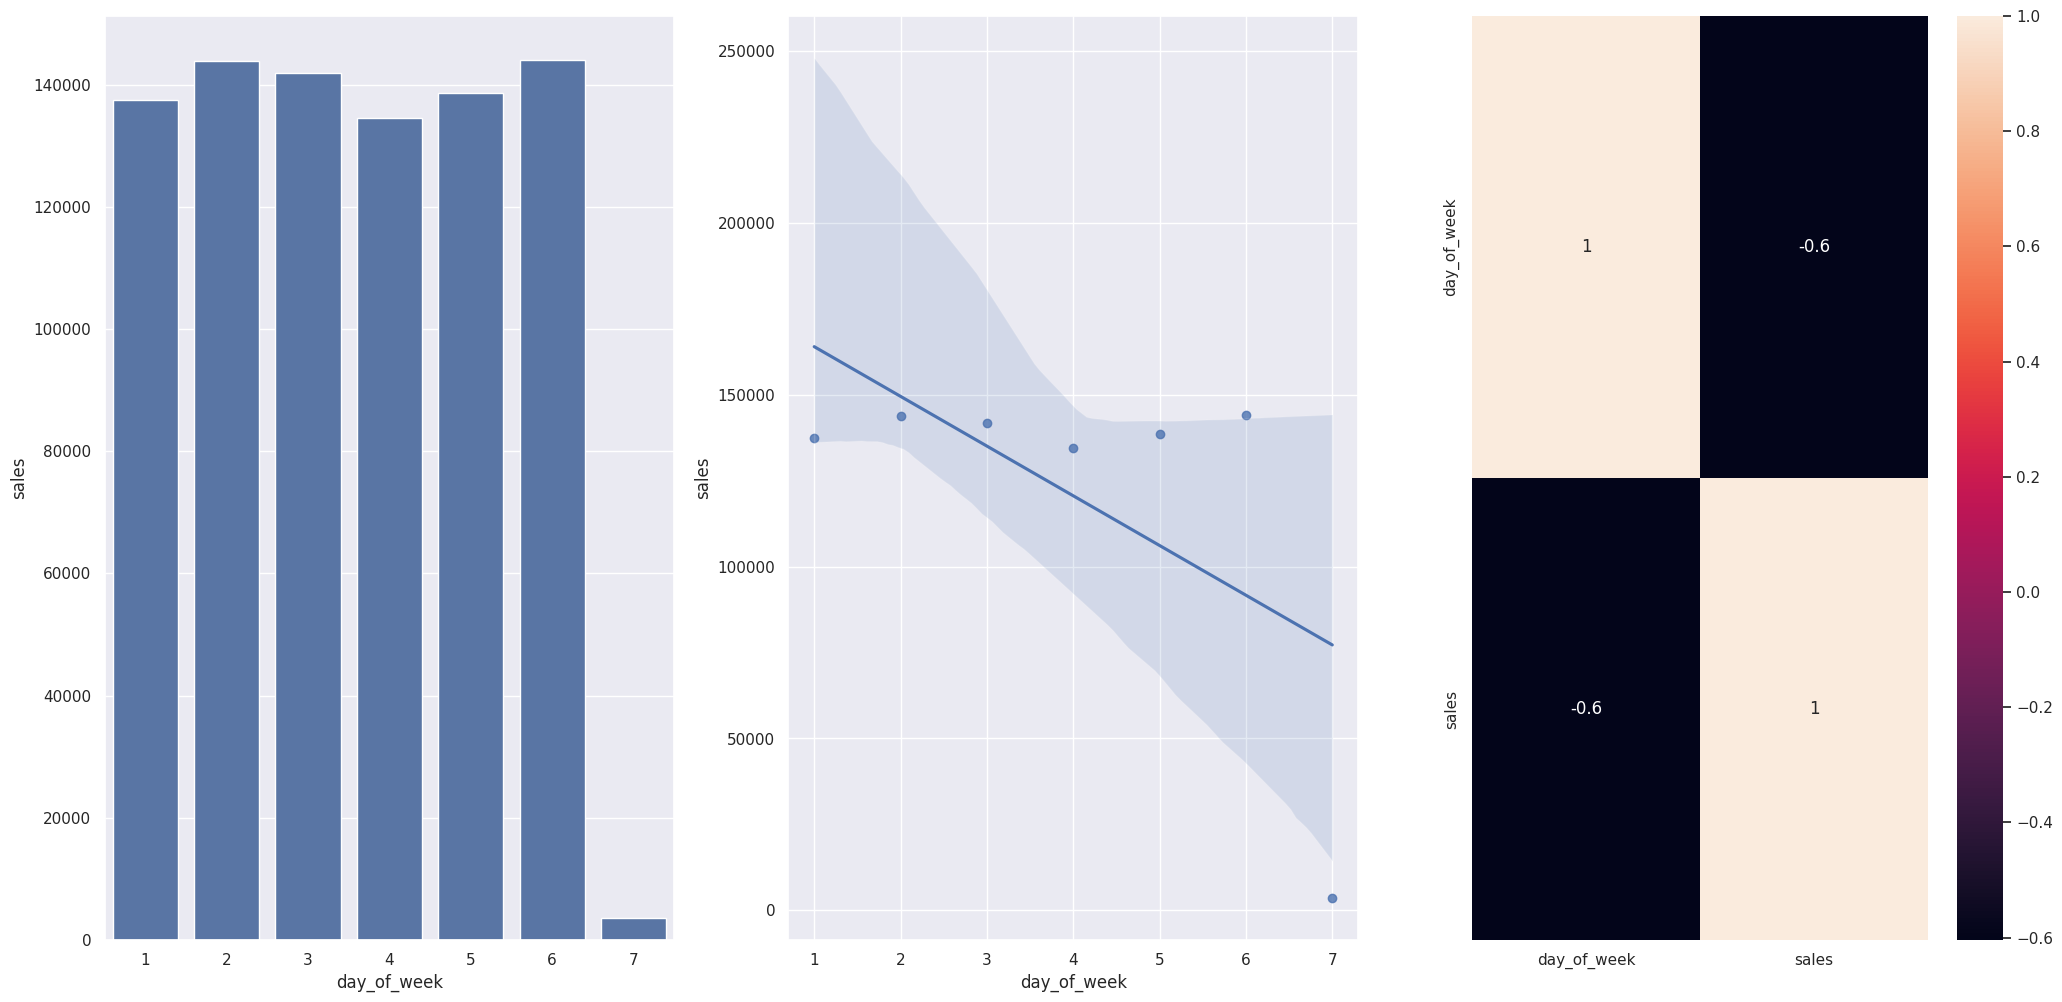

In [51]:
aux1 = (
    df4.loc[:, ["day_of_week", "sales"]].groupby(["day_of_week"]).count().reset_index()
)

plt.subplot(1, 3, 1)
sns.barplot(x="day_of_week", y="sales", data=aux1)

plt.subplot(1, 3, 2)
sns.regplot(x="day_of_week", y="sales", data=aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method="pearson"), annot=True)

### **H12.** Stores should sell less during school holidays.  
**FALSE:** On average school holidays sell more.  
Important to note that on July and August the total amount sold on school holidays are respectively close and higher the regular days.

<Axes: xlabel='month', ylabel='sales'>

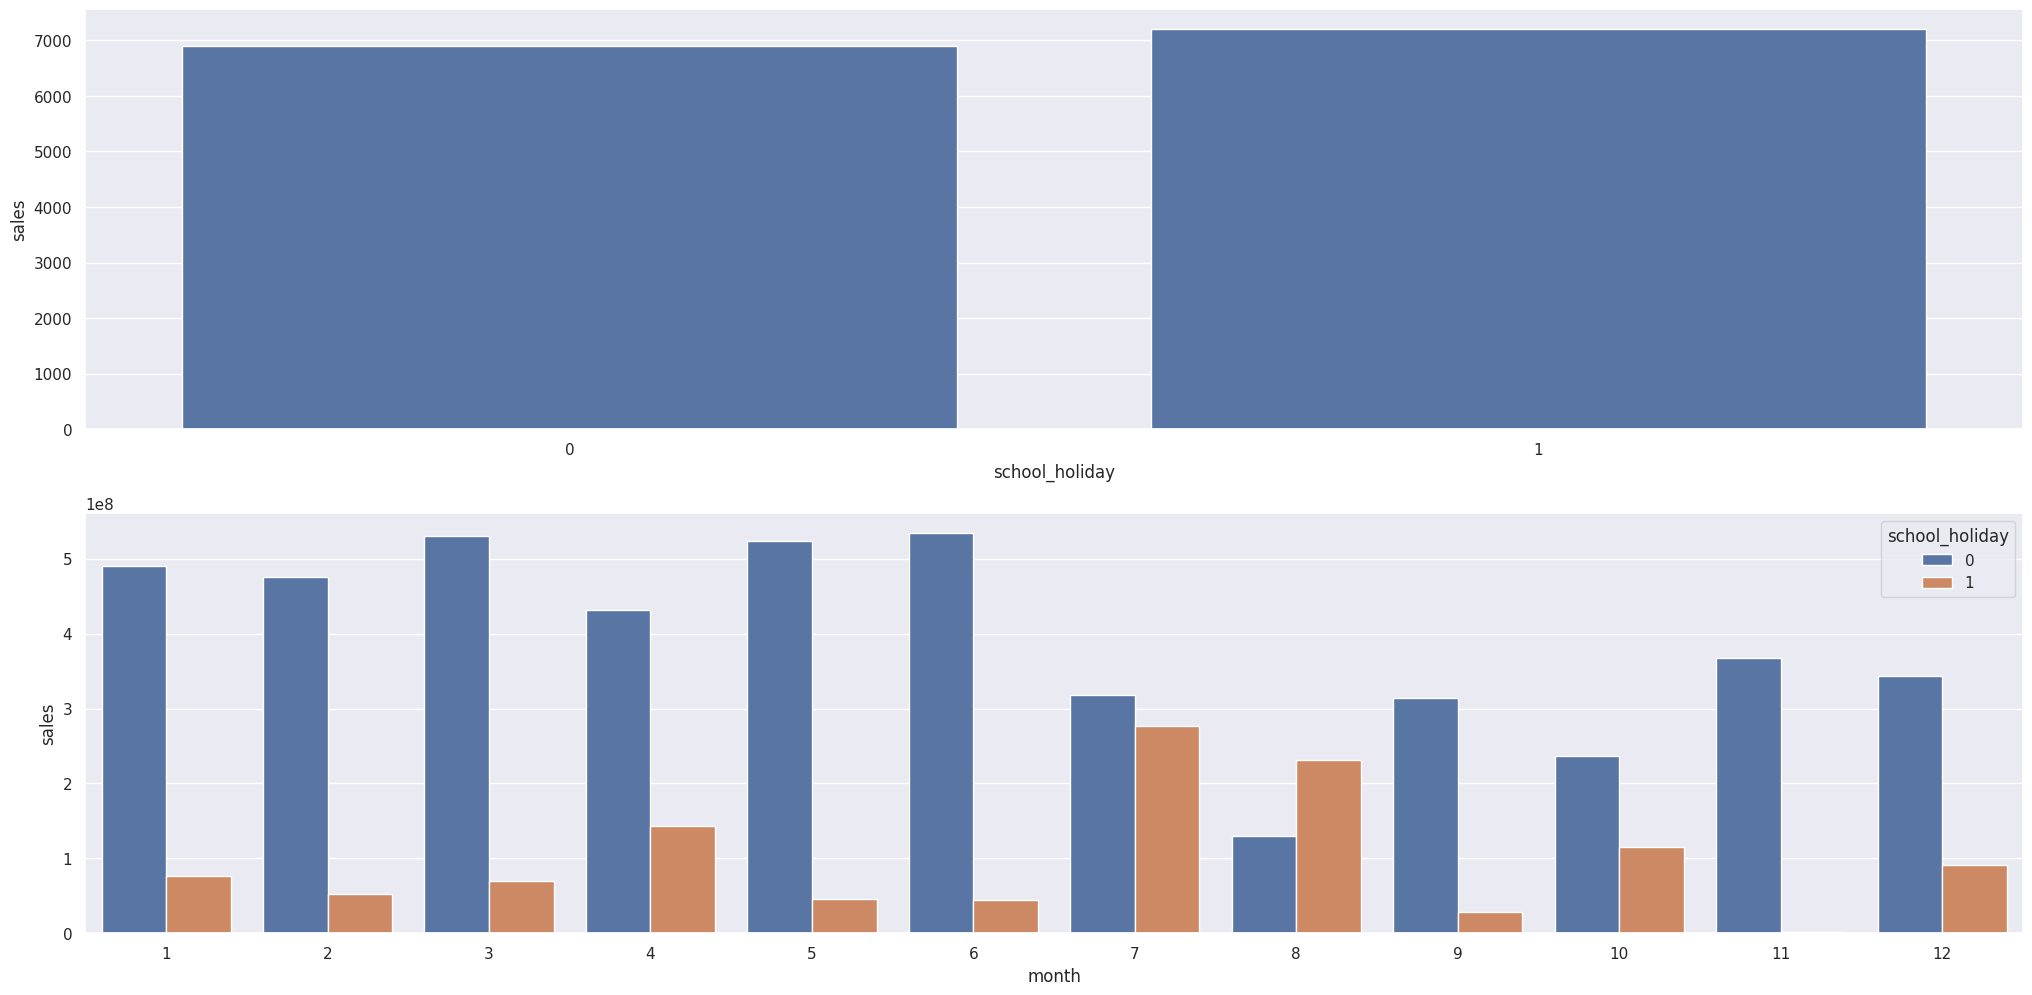

In [52]:
aux1 = (
    df4.loc[:, ["school_holiday", "sales"]]
    .groupby(["school_holiday"])
    .mean()
    .reset_index()
)

plt.subplot(2, 1, 1)
sns.barplot(x="school_holiday", y="sales", data=aux1)

plt.subplot(2, 1, 2)
aux2 = (
    df4.loc[:, ["month", "school_holiday", "sales"]]
    .groupby(["month", "school_holiday"])
    .sum()
    .reset_index()
)

aux2["school_holiday"] = aux2["school_holiday"].astype(str)

sns.barplot(x="month", y="sales", hue="school_holiday", data=aux2)

### **Hypothesis Table**

In [53]:
tab = [
    ["Hypothesis", "Conclusion", "Relevance"],
    ["H1", "True", "Low"],
    ["H2", "False", "Medium"],
    ["H3", "False", "Medium"],
    ["H4", "False", "Low"],
    ["H5", "-", "-"],
    ["H6", "False", "Low"],
    ["H7", "True", "Medium"],
    ["H8", "False", "High"],
    ["H9", "True", "High"],
    ["H10", "False", "High"],
    ["H11", "True", "High"],
    ["H12", "False", "Low"],
]
print(tabulate(tab, headers="firstrow"))

Hypothesis    Conclusion    Relevance
------------  ------------  -----------
H1            True          Low
H2            False         Medium
H3            False         Medium
H4            False         Low
H5            -             -
H6            False         Low
H7            True          Medium
H8            False         High
H9            True          High
H10           False         High
H11           True          High
H12           False         Low


## 4.3 - Multivariate Analysis

## 4.3.1 - Numerical Attrributes

<Axes: >

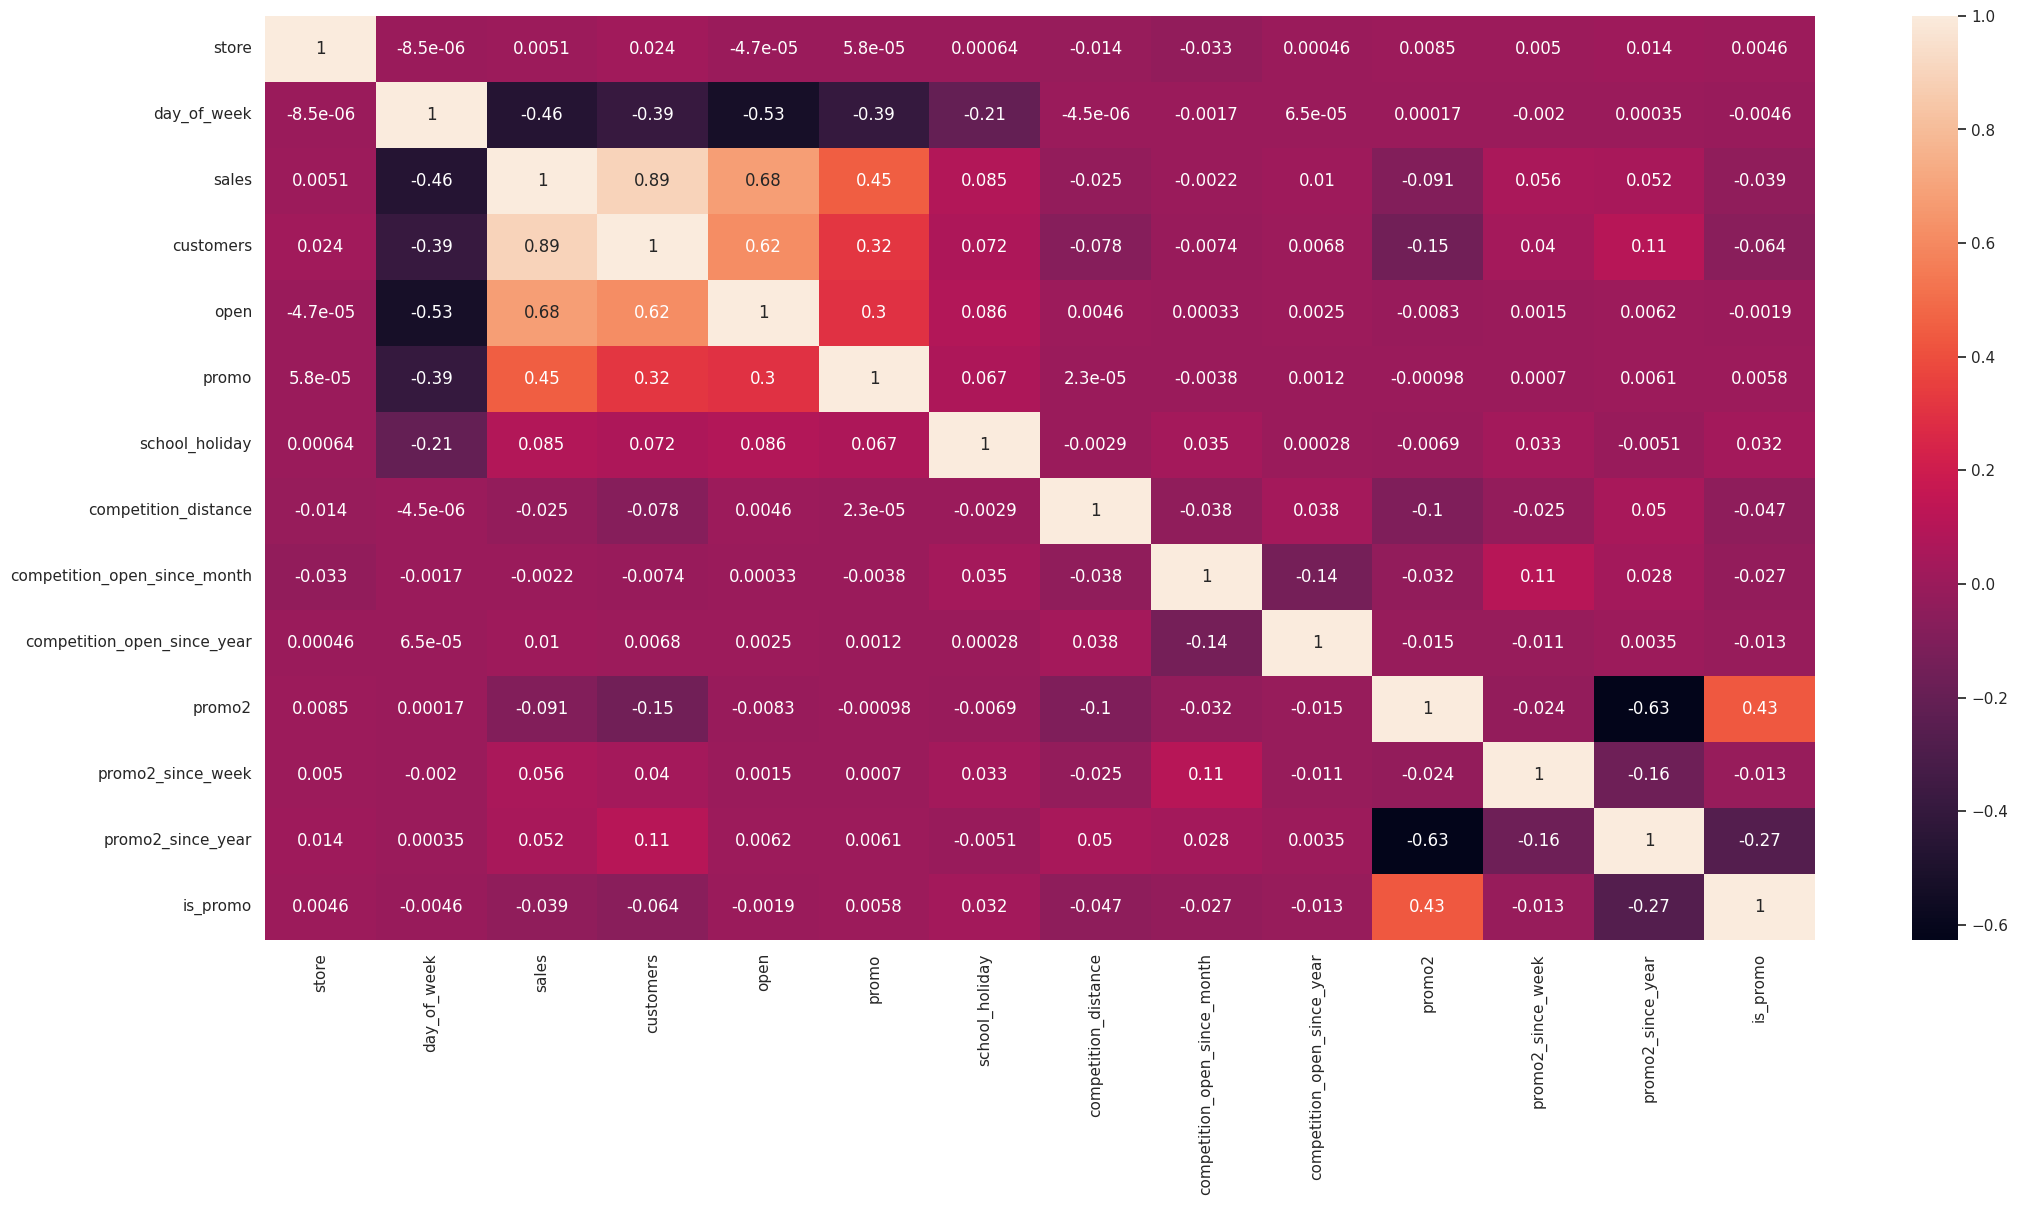

In [54]:
correlation = num_attributes.corr(method="pearson")
sns.heatmap(correlation, annot=True)

## 4.3.2- Categorical Attributes

<Axes: >

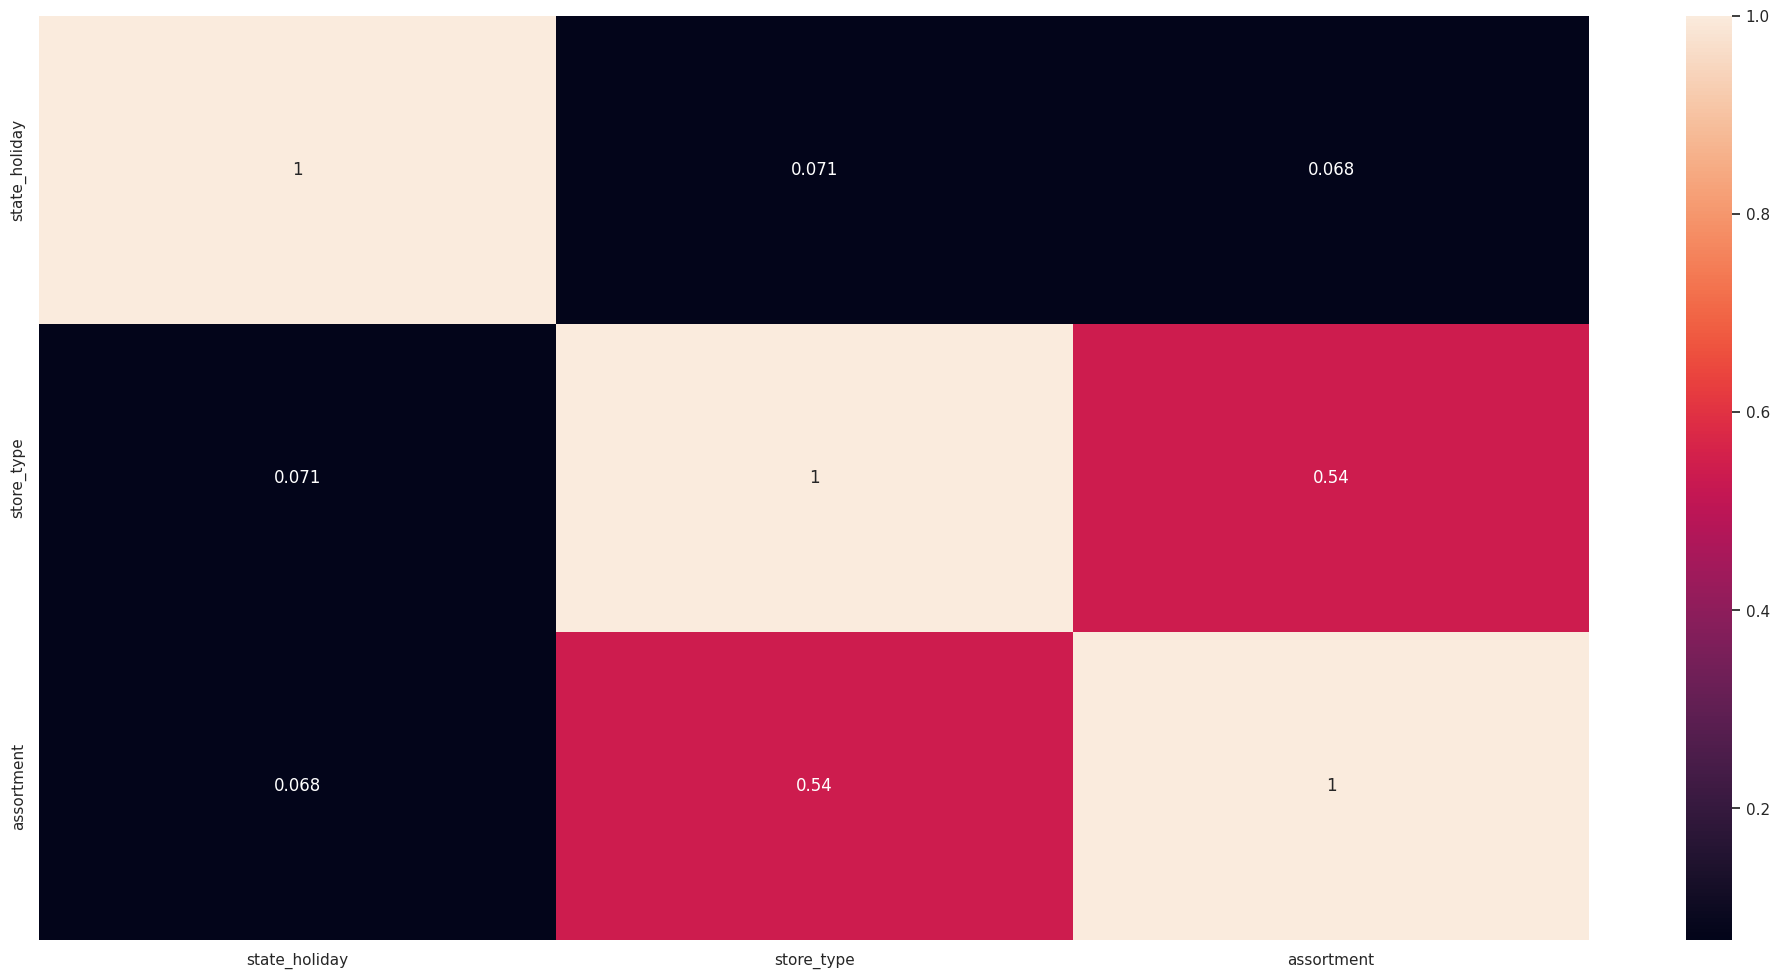

In [55]:
# Calculate cramer V
a = df4.select_dtypes(include="object")

a1 = cramer_v(a["state_holiday"], a["state_holiday"])
a2 = cramer_v(a["state_holiday"], a["store_type"])
a3 = cramer_v(a["state_holiday"], a["assortment"])
a4 = cramer_v(a["store_type"], a["state_holiday"])
a5 = cramer_v(a["store_type"], a["store_type"])
a6 = cramer_v(a["store_type"], a["assortment"])
a7 = cramer_v(a["assortment"], a["state_holiday"])
a8 = cramer_v(a["assortment"], a["store_type"])
a9 = cramer_v(a["assortment"], a["assortment"])

# Final dataset
d = pd.DataFrame(
    {
        "state_holiday": [a1, a2, a3],
        "store_type": [a4, a5, a6],
        "assortment": [a7, a8, a9],
    }
)
d = d.set_index(d.columns)
sns.heatmap(d, annot=True)

# 5.0 - Data Preparation

In [56]:
df5 = df4.copy()

## 5.1 - Normalization

Nome of the variables have Gaussian Distribution, so normalization is not needed.  
This can be seen on seen on univariable analysis for numerical attributes on section 4.1.2

## 5.2 - Rescaling

In [57]:
a = df5.select_dtypes(include=["int64", "float64"])

<Axes: xlabel='competition_time_month'>

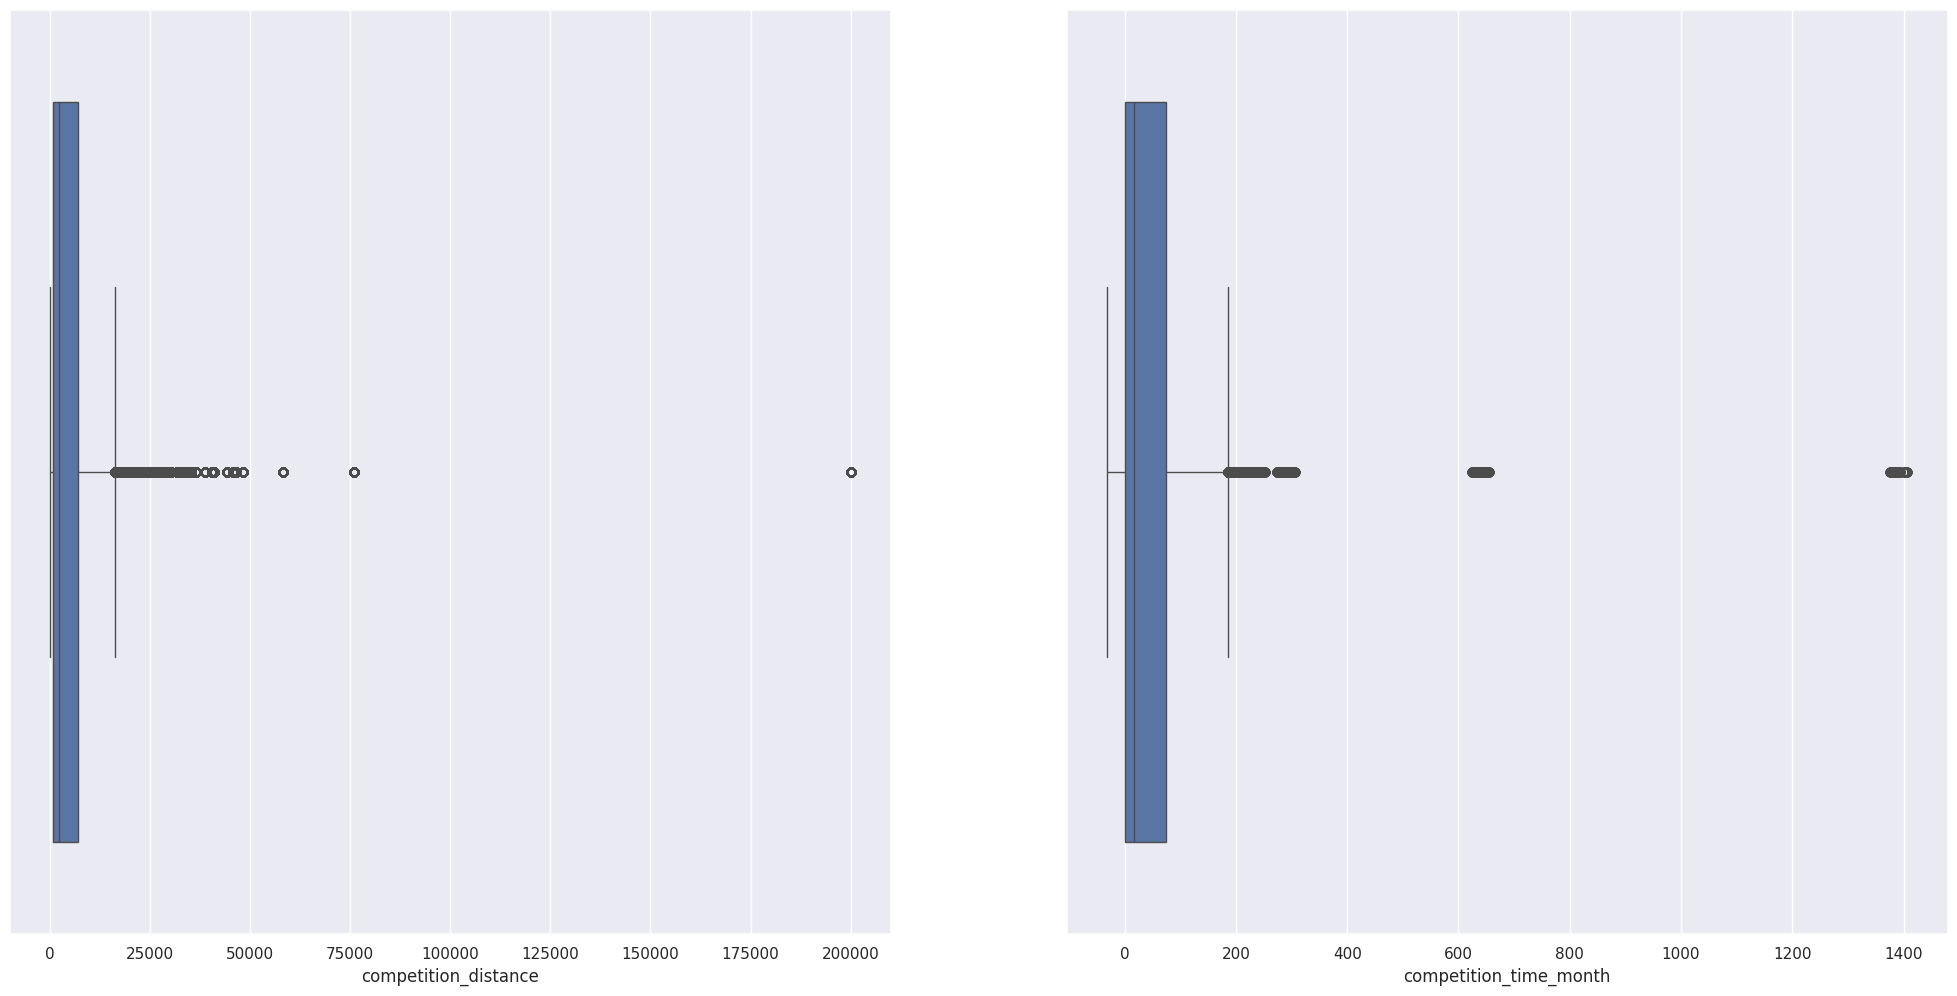

In [58]:
plt.subplot(1, 2, 1)
sns.boxplot(x=a["competition_distance"])

plt.subplot(1, 2, 2)
sns.boxplot(x=a["competition_time_month"])

In [59]:
# Rescale time features
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5["competition_distance"] = rs.fit_transform(df5[["competition_distance"]].values)
pickle.dump(rs, open("../parameters/competition_distance_scaler.pkl", "wb"))

# competition time month
df5["competition_time_month"] = rs.fit_transform(df5[["competition_time_month"]].values)
pickle.dump(rs, open("../parameters/competition_time_month_scaler.pkl", "wb"))

# promo time week
df5["promo_time_week"] = mms.fit_transform(df5[["promo_time_week"]].values)
pickle.dump(mms, open("../parameters/promo_time_week_scaler.pkl", "wb"))

# year
df5["year"] = mms.fit_transform(df5[["year"]].values)
pickle.dump(mms, open("../parameters/year_scaler.pkl", "wb"))

## 5.3 - Transformation

### 5.3.1 - Encoding

In [60]:
# state holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=["state_holiday"], columns=["state_holiday"])

In [61]:
# store type - Label Encoder
le = LabelEncoder()
df5["store_type"] = le.fit_transform(df5["store_type"])
pickle.dump(le, open("../parameters/store_type_scaler.pkl", "wb"))

In [62]:
# assortment - Ordinal Encoding
assortment_dict = {
    "basic": 1,
    "extra": 2,
    "extended": 3,
}

df5["assortment"] = df5["assortment"].map(assortment_dict)

### 5.3.2 - Response Variable Transformation

In [63]:
df5["sales"] = np.log1p(df5["sales"])

<Axes: xlabel='sales', ylabel='Count'>

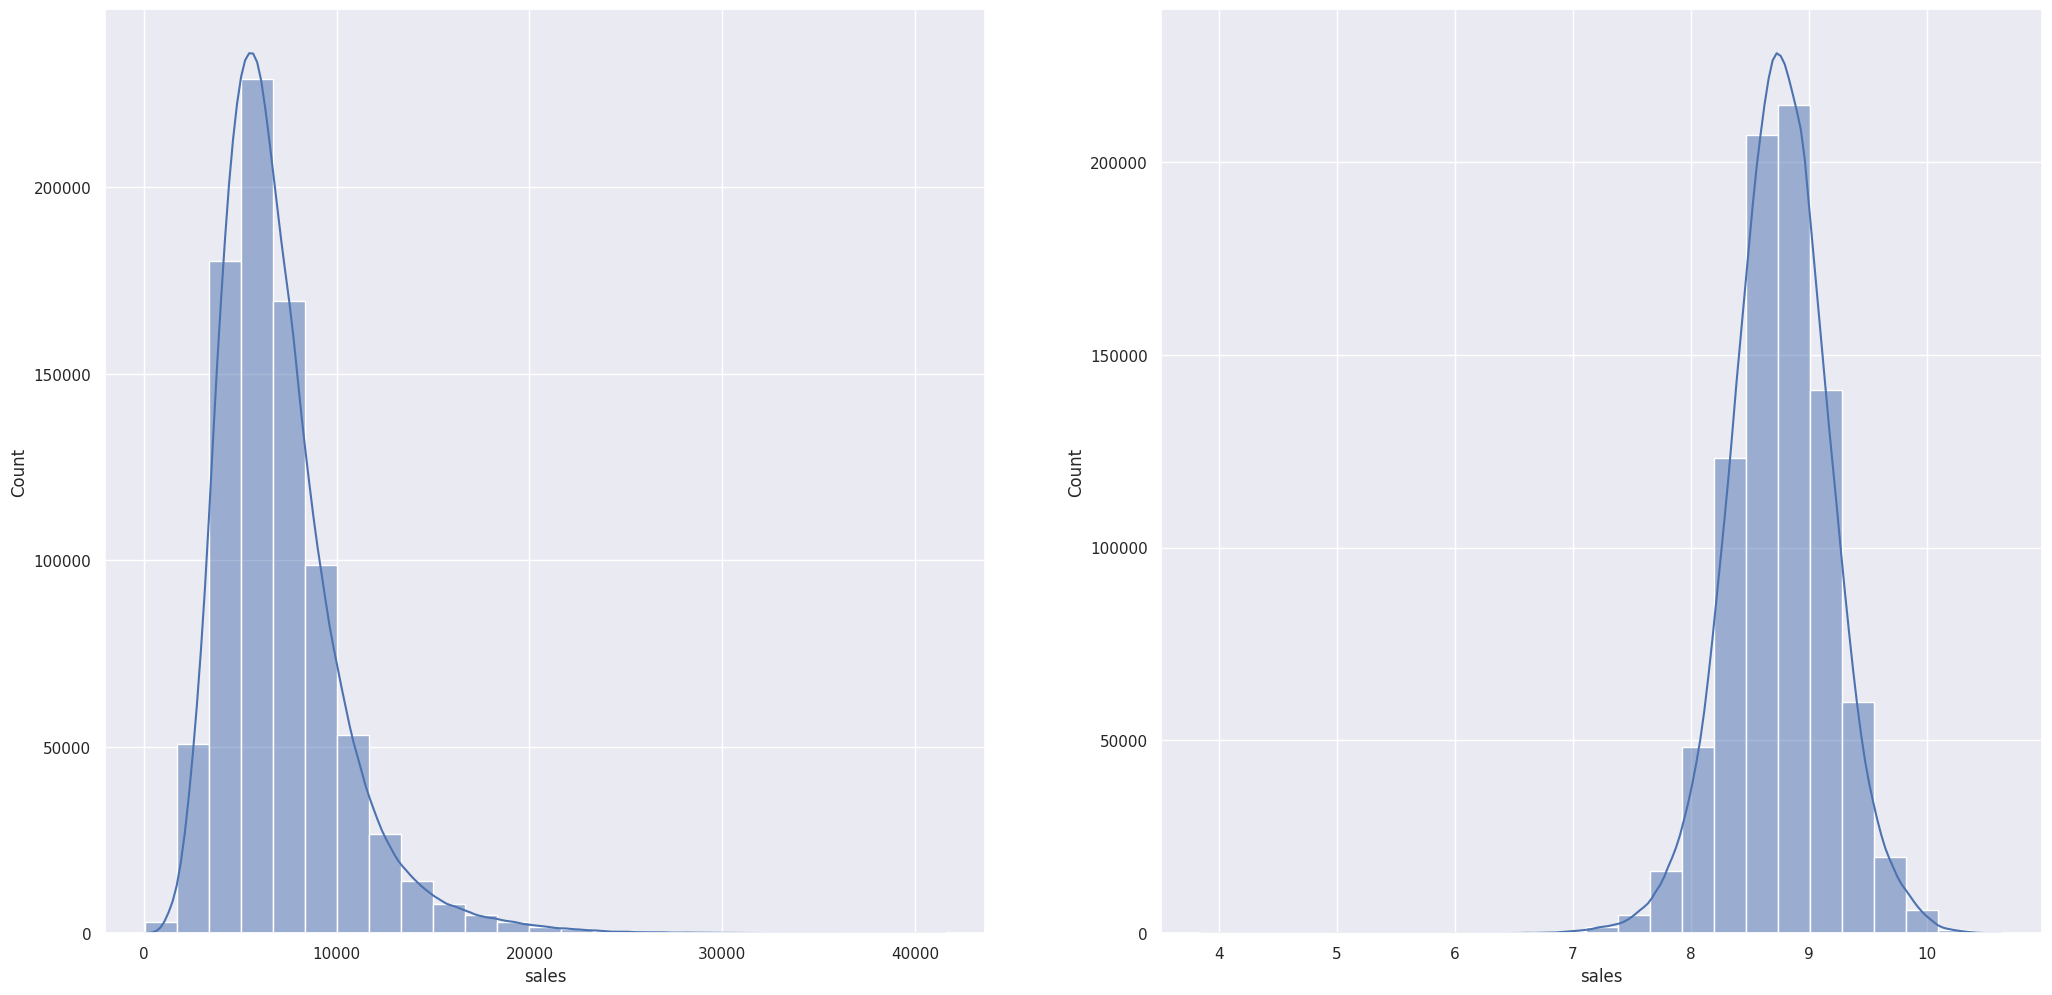

In [64]:
plt.subplot(1, 2, 1)
sns.histplot(df4["sales"], bins=25, kde=True)

plt.subplot(1, 2, 2)
sns.histplot(df5["sales"], bins=25, kde=True)

### 5.3.3 - Natural Transformation

In [65]:
# month
df5["month_sin"] = df5["month"].apply(lambda x: np.sin(x * (2.0 * np.pi / 12)))
df5["month_cos"] = df5["month"].apply(lambda x: np.cos(x * (2.0 * np.pi / 12)))

# day
df5["day_sin"] = df5["day"].apply(lambda x: np.sin(x * (2.0 * np.pi / 30)))
df5["day_cos"] = df5["day"].apply(lambda x: np.cos(x * (2.0 * np.pi / 30)))

# day of week
df5["day_of_week_sin"] = df5["day_of_week"].apply(
    lambda x: np.sin(x * (2.0 * np.pi / 7))
)
df5["day_of_week_cos"] = df5["day_of_week"].apply(
    lambda x: np.cos(x * (2.0 * np.pi / 7))
)

# week of year
df5["week_of_year_sin"] = df5["week_of_year"].apply(
    lambda x: np.sin(x * (2.0 * np.pi / 52))
)
df5["week_of_year_cos"] = df5["week_of_year"].apply(
    lambda x: np.cos(x * (2.0 * np.pi / 52))
)

# 6.0 - Feature Selection

In [66]:
df6 = df5.copy()

In [67]:
cols_drop = [
    "day_of_week",
    "day",
    "month",
    "week_of_year",
    "promo_since",
    "competition_since",
    "year_week",
]

df6 = df6.drop(cols_drop, axis=1)

df6.columns

Index(['store', 'date', 'sales', 'promo', 'school_holiday', 'store_type',
       'assortment', 'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'is_promo', 'year', 'competition_time_month',
       'promo_time_week', 'state_holiday_christmas',
       'state_holiday_easter_holiday', 'state_holiday_public_holiday',
       'state_holiday_regular_day', 'month_sin', 'month_cos', 'day_sin',
       'day_cos', 'day_of_week_sin', 'day_of_week_cos', 'week_of_year_sin',
       'week_of_year_cos'],
      dtype='object')

## 6.1 - Split Dataset

In [68]:
X_train = df6.copy()
y_train = X_train["sales"]

In [69]:
# Clean Test Dataset
X_test = test.copy()

X_test = rename_cols(X_test).copy()
X_test = fillout_na(X_test).copy()
X_test = change_types(X_test).copy()
X_test = feature_eng(X_test).copy()
X_test = filter_features(X_test).copy()
X_test = data_preparation(X_test).copy()

y_test = X_test["sales"]

## 6.2 - Boruta Selection

In [70]:
# # Train and Test datasets for Boruta
# X_train_n = X_train.drop(["date", "sales"], axis=1).values
# y_train_n = y_train.values.ravel()

# # Define RandonForestRegressor
# rf = RandomForestRegressor(n_jobs=-1)

# # Define Boruta
# boruta = BorutaPy(rf, n_estimators="auto", verbose=2, random_state=42).fit(
#     X_train_n, y_train_n
# )

### 6.2.1 - Best Features From Boruta

In [71]:
# cols_selected = boruta.support_.tolist()

# # Best Features
# X_train_fs = X_train.drop(["date", "sales"], axis=1)
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# # Features Not Selected
# cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

In [72]:
# cols_selected_boruta

In [73]:
cols_selected_boruta = [
    "store",
    "promo",
    "store_type",
    "assortment",
    "competition_distance",
    "competition_open_since_month",
    "competition_open_since_year",
    "promo2",
    "promo2_since_week",
    "promo2_since_year",
    "competition_time_month",
    "promo_time_week",
    "month_sin",
    "month_cos",
    "day_sin",
    "day_cos",
    "day_of_week_sin",
    "day_of_week_cos",
    "week_of_year_sin",
    "week_of_year_cos",
]

# added "month_sin" and "week_of_year_sin"

In [74]:
# cols_not_selected_boruta

In [75]:
cols_not_selected_boruta = [
    "is_promo",
    "school_holiday",
    "state_holiday_christmas",
    "state_holiday_easter_holiday",
    "state_holiday_public_holiday",
    "state_holiday_regular_day",
    "year",
]

# consider use "year" feature in future model tunning

In [76]:
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(["date", "sales"])

# 7.0 - Machine Learning Model

In [77]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time Series Data Preparation
x_train_full = X_train[cols_selected_boruta_full]

## 7.1 - Average Model - Baseline

In [78]:
aux1 = x_test.copy()
aux1["sales"] = y_test.copy()

# Prediction
aux2 = (
    aux1.loc[:, ["store", "sales"]]
    .groupby("store")
    .mean()
    .reset_index()
    .rename(columns={"sales": "predictions"})
)
aux1 = pd.merge(aux1, aux2, how="left", on="store")
yhat_baseline = aux1["predictions"]

In [79]:
# Performance
baseline_performace = ml_error(
    "Average Model", np.expm1(y_test), np.expm1(yhat_baseline)
)
baseline_performace

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.8,0.2064,1835.14


## 7.2 - Linear Regression

In [80]:
# Model
lr = LinearRegression().fit(x_train, y_train)

# Prediction
yhat_lr = lr.predict(x_test)

# Performance
lr_performance = ml_error("Linear Regression", np.expm1(y_test), np.expm1(yhat_lr))
lr_performance

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,2078.71,0.3047,3102.64


### 7.2.1 - Linear Regression - Cross Validation

In [81]:
lr_performance_cv = cross_validation(x_train_full, 5, "Linear Regression", lr)
lr_performance_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,1927.38 +/- 95.66,0.298 +/- 0.0153,2724.56 +/- 179.52


## 7.3 - Linear Regression - Lasso

In [82]:
# Model
lrr = Lasso(alpha=0.01).fit(x_train, y_train)

# Prediction
yhat_lrr = lrr.predict(x_test)

# Performance
lrr_performance = ml_error("Lasso", np.expm1(y_test), np.expm1(yhat_lrr))
lrr_performance

,Model Name,MAE,MAPE,RMSE
0,Lasso,1890.57,0.2893,2741.42


### 7.3.1 - Lasso - Cross Validation

In [83]:
lrr_performance_cv = cross_validation(x_train_full, 5, "Lasso", lrr)
lrr_performance_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,1947.16 +/- 132.37,0.2863 +/- 0.0033,2814.28 +/- 214.06


## 7.4 - Random Forest Regressor

In [84]:
# Model
rf = RandomForestRegressor(n_estimators=100, random_state=42).fit(x_train, y_train)

# Prediction
yhat_rf = rf.predict(x_test)

# Performance
rf_performance = ml_error("Random Forest", np.expm1(y_test), np.expm1(yhat_rf))
rf_performance

,Model Name,MAE,MAPE,RMSE
0,Random Forest,651.34,0.0958,1023.1


### 7.4.1 - Random Forest - Cross Validation

In [85]:
rf_performance_cv = cross_validation(
    x_train_full, 5, "Random Forest", rf, verbose=False
)
rf_performance_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest,733.8 +/- 117.35,0.106 +/- 0.0158,1102.23 +/- 178.97


## 7.5 - XGBoost Regressor

In [86]:
# Model
xgb_model = xgb.XGBRegressor().fit(x_train, y_train)

# Prediction
yhat_xgb = xgb_model.predict(x_test)

# Performance
xgb_performance = ml_error("XGBoost", np.expm1(y_test), np.expm1(yhat_xgb))
xgb_performance

,Model Name,MAE,MAPE,RMSE
0,XGBoost,1130.0,0.1671,1632.44


### 7.5.1 - XGBoost - Cross Validation

In [87]:
xgb_performance_cv = cross_validation(
    x_train_full, 5, "XGBoost", xgb_model, verbose=False
)
xgb_performance_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost,981.66 +/- 103.56,0.1409 +/- 0.0108,1401.81 +/- 145.51


## 7.7 - Compare Performance

### 7.7.1 - Basic Performance

In [89]:
models_performance = pd.concat(
    [
        baseline_performace,
        lr_performance,
        lrr_performance,
        rf_performance,
        xgb_performance,
    ]
)
models_performance.sort_values("RMSE", inplace=True)
models_performance.reset_index(inplace=True, drop=True)
models_performance

,Model Name,MAE,MAPE,RMSE
0,Random Forest,651.34,0.0958,1023.10
1,XGBoost,1130.00,0.1671,1632.44
2,Average Model,1354.80,0.2064,1835.14
3,Lasso,1890.57,0.2893,2741.42
4,Linear Regression,2078.71,0.3047,3102.64


#### Conclusion: Linear Models do not perform better than a average model, which means this data needs a more complex model.

In [90]:
# save dataframe to csv
models_performance.to_csv("../data/processed/performance.csv")

### 7.7.2 - Cross Validation Performance

In [91]:
models_performance_cv = pd.concat(
    [
        lr_performance_cv,
        lrr_performance_cv,
        rf_performance_cv,
        xgb_performance_cv,
    ]
)
models_performance_cv.sort_values("RMSE CV", inplace=True)
models_performance_cv.reset_index(inplace=True, drop=True)
models_performance_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest,733.8 +/- 117.35,0.106 +/- 0.0158,1102.23 +/- 178.97
1,XGBoost,981.66 +/- 103.56,0.1409 +/- 0.0108,1401.81 +/- 145.51
2,Linear Regression,1927.38 +/- 95.66,0.298 +/- 0.0153,2724.56 +/- 179.52
3,Lasso,1947.16 +/- 132.37,0.2863 +/- 0.0033,2814.28 +/- 214.06


In [92]:
# save dataframe to csv
models_performance_cv.to_csv("../data/processed/performance_cv.csv")

# 8.0 - Hyperparameter Fine Tunning

## 8.1 - Random Search

In [93]:
params = {
    "n_estimators": [1500, 1700, 2500, 3000, 3500],
    "eta": [0.01, 0.03, 0.05, 0.07, 0.09],
    "max_depth": [3, 5, 7, 9],
    "subsample": [0.1, 0.3, 0.5, 0.7],
    "colsample_bytree": [0.3, 0.7, 0.9],
    "min_child_weight": [3, 8, 15],
}

MAX_EVAL = 10

In [94]:
final_performance = pd.DataFrame()

for i in range(MAX_EVAL):
    # choose parameters randomly
    hp = {k: random.sample(v, 1)[0] for k, v in params.items()}
    print(hp)

    # Model
    xgb_model = xgb.XGBRegressor(
        objective="reg:squarederror",
        n_estimators=hp["n_estimators"],
        eta=hp["eta"],
        max_depth=hp["max_depth"],
        subsample=hp["subsample"],
        colsample_bytree=hp["colsample_bytree"],
        min_child_weight=hp["min_child_weight"],
    )

    # Performance
    xgb_performance = cross_validation(
        x_train_full, 5, "XGBoost Regressor", xgb_model, verbose=False
    )
    final_performance = pd.concat([final_performance, xgb_performance])

final_performance.reset_index(inplace=True, drop=True)
final_performance

{'n_estimatores': 3000, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 3}
{'n_estimatores': 1500, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 3}
{'n_estimatores': 2500, 'eta': 0.07, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 15}
{'n_estimatores': 3500, 'eta': 0.07, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 8}
{'n_estimatores': 1500, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 8}
{'n_estimatores': 1700, 'eta': 0.05, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 3}
{'n_estimatores': 3500, 'eta': 0.05, 'max_depth': 3, 'subsample': 0.3, 'colsample_bytree': 0.7, 'min_child_weight': 8}
{'n_estimatores': 3500, 'eta': 0.09, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 15}
{'n_estimatores': 1500, 'eta': 0.01, 'max_dept

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1389.66 +/- 84.77,0.1994 +/- 0.0056,2014.23 +/- 119.86
0,XGBoost Regressor,1725.05 +/- 103.21,0.2516 +/- 0.0033,2491.71 +/- 163.18
0,XGBoost Regressor,775.79 +/- 111.78,0.1101 +/- 0.0108,1118.2 +/- 162.58
0,XGBoost Regressor,1051.64 +/- 103.09,0.1515 +/- 0.0096,1512.99 +/- 152.44
0,XGBoost Regressor,1473.41 +/- 89.11,0.2114 +/- 0.004,2143.95 +/- 132.27
0,XGBoost Regressor,755.11 +/- 107.78,0.1079 +/- 0.0123,1096.39 +/- 154.98
0,XGBoost Regressor,1102.13 +/- 87.62,0.1591 +/- 0.0069,1586.08 +/- 127.77
0,XGBoost Regressor,990.02 +/- 107.83,0.1435 +/- 0.0111,1418.94 +/- 152.22
0,XGBoost Regressor,1696.98 +/- 102.09,0.2463 +/- 0.0034,2456.53 +/- 159.8
0,XGBoost Regressor,804.01 +/- 102.79,0.1151 +/- 0.0105,1153.01 +/- 152.04


In [95]:
# save dataframe to csv
final_performance.to_csv("../data/processed/final_performance.csv")

## 8.2 - Final Model

In [103]:
params_tuned = {
    "n_estimators": 1700,
    "eta": 0.05,
    "max_depth": 9,
    "subsample": 0.7,
    "colsample_bytree": 0.9,
    "min_child_weight": 3,
}

In [104]:
# Model
xgb_model_tuned = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=params_tuned["n_estimators"],
    eta=params_tuned["eta"],
    max_depth=params_tuned["max_depth"],
    subsample=params_tuned["subsample"],
    colsample_bytree=params_tuned["colsample_bytree"],
    min_child_weight=params_tuned["min_child_weight"],
).fit(x_train, y_train)

# Prediction
yhat_xgb_tuned = xgb_model_tuned.predict(x_test)

# Performance
xgb_performance_tuned = ml_error(
    "XGBoost Regressor", np.expm1(y_test), np.expm1(yhat_xgb_tuned)
)
xgb_performance_tuned.reset_index(inplace=True, drop=True)
xgb_performance_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,786.75,0.1163,1143.75


In [105]:
# Save trained model
pickle.dump(xgb_model_tuned, open("../models/xgb_rossmann.pkl", "wb"))

In [106]:
# save dataframe to csv
xgb_performance_tuned.to_csv("../data/processed/xgb_performance_tuned.csv")

# 9.0 - Error Interpretation

In [107]:
df9 = X_test[cols_selected_boruta_full]

# rescale
df9["sales"] = np.expm1(df9["sales"])
df9["predictions"] = np.expm1(yhat_xgb_tuned)

df91 = df9.loc[:, ["store", "predictions"]]

## 9.1 - Business Performance

In [108]:
ERROR = xgb_performance_tuned["MAPE"][0]
BEST_ERROR = 1 + ERROR
WORST_ERROR = 1 - ERROR

# sum of predictions
df92 = df91.groupby("store").sum().reset_index()

df92["best_scenario"] = df92["predictions"] * BEST_ERROR
df92["worst_scenario"] = df92["predictions"] * WORST_ERROR
df92["MAE"] = df92["best_scenario"] - df92["predictions"]
df92.sample(5)

,store,predictions,best_scenario,worst_scenario,MAE
1028,1029,195004.046875,217683.015625,172325.078125,22678.968750
491,492,282124.906250,314936.031250,249313.781250,32811.125000
924,925,245256.015625,273779.281250,216732.750000,28523.265625
449,450,328680.343750,366905.875000,290454.812500,38225.531250
68,69,352858.125000,393895.531250,311820.718750,41037.406250


<Axes: xlabel='store', ylabel='MAPE'>

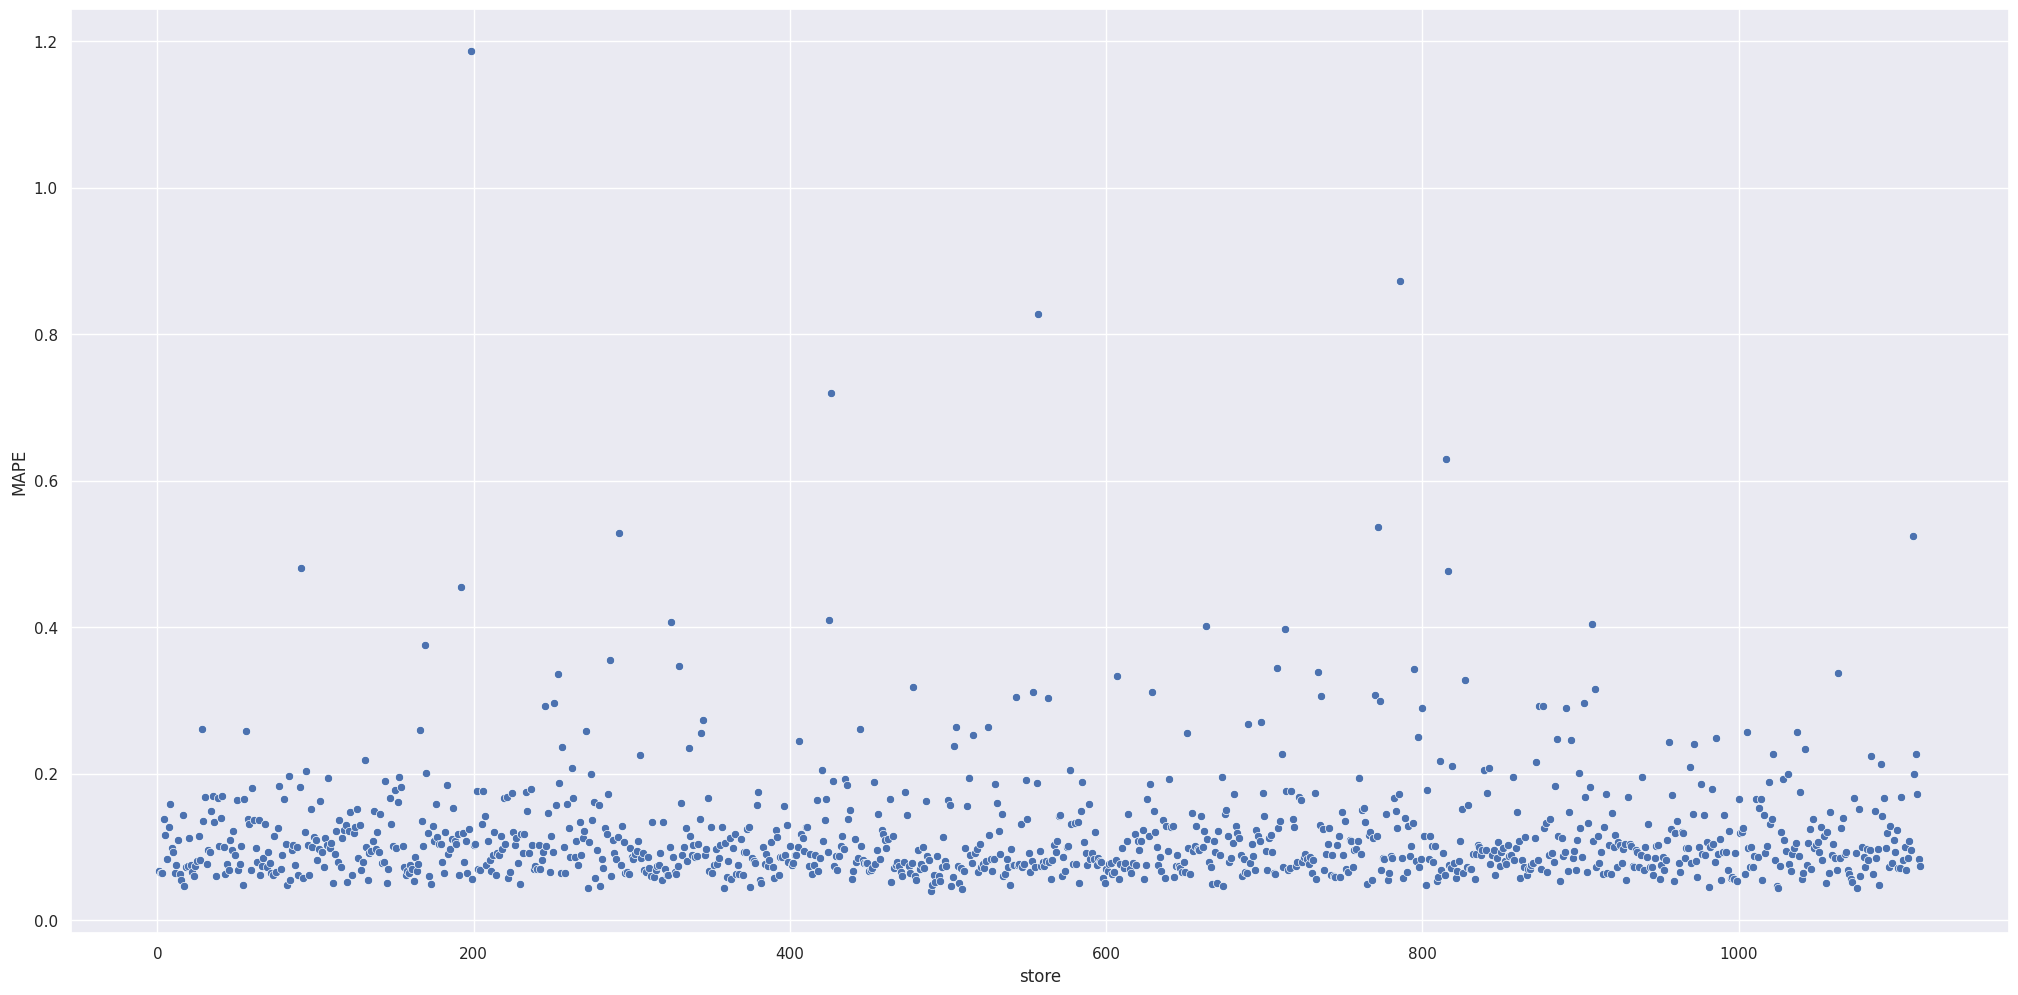

In [109]:
# MAPE for each store
df9_aux = (
    df9.loc[:, ["store", "sales", "predictions"]]
    .groupby("store")
    .apply(lambda x: mean_absolute_percentage_error(x["sales"], x["predictions"]))
    .reset_index()
    .rename(columns={0: "MAPE"})
)

# Merge
df93 = pd.merge(df92, df9_aux, how="inner", on="store")

sns.scatterplot(data=df93, x="store", y="MAPE")

## 9.2 - Total Performance

In [110]:
df94 = (
    df92.loc[:, ["predictions", "worst_scenario", "best_scenario"]]
    .apply(lambda x: np.sum(x), axis=0)
    .reset_index()
    .rename(columns={"index": "Scenario", 0: "Values"})
)
df94["Values"] = df94["Values"].map("€ {:,.2f}".format)
df94

,Scenario,Values
0,predictions,"€ 282,895,872.00"
1,worst_scenario,"€ 249,995,088.00"
2,best_scenario,"€ 315,796,640.00"


## 9.3 - Machine Learning Performance

In [111]:
df9["error"] = df9["sales"] - df9["predictions"]
df9["error_rate"] = df9["predictions"] / df9["sales"]

<Axes: xlabel='predictions', ylabel='error'>

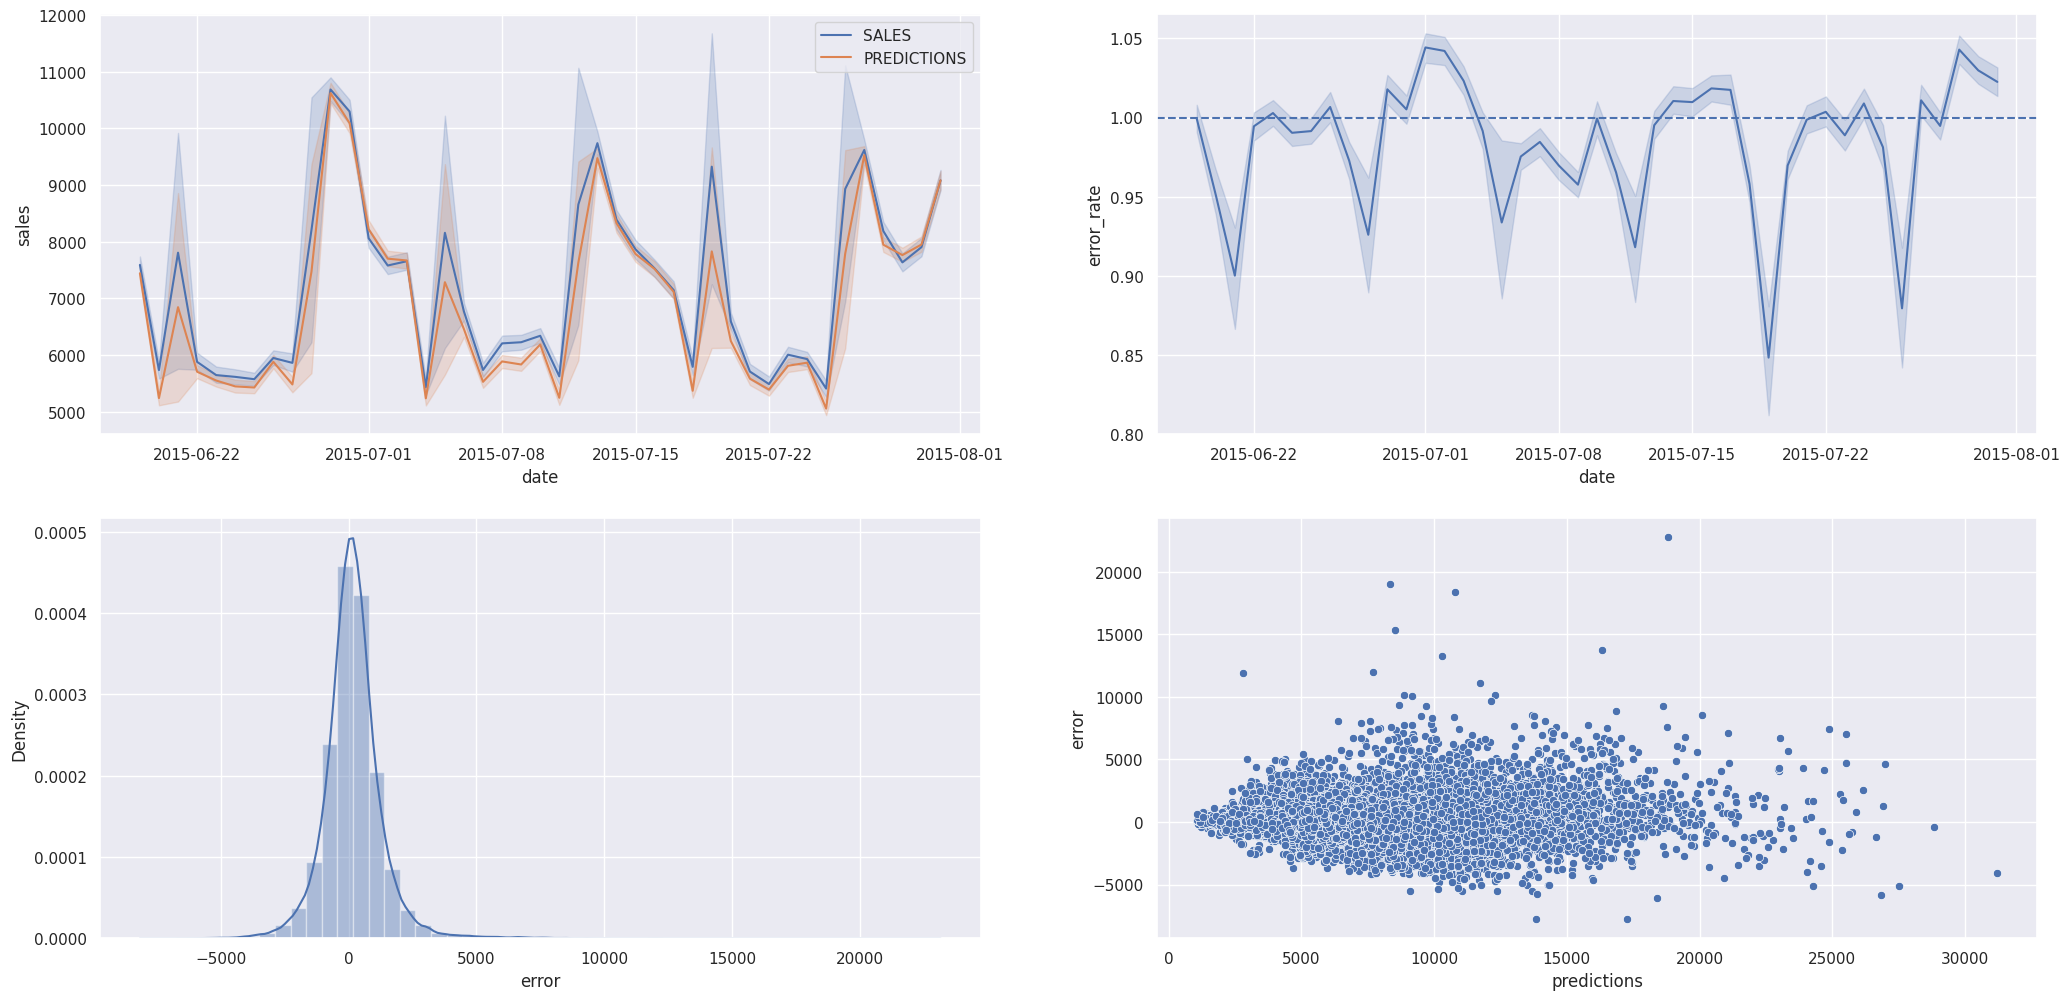

In [112]:
plt.subplot(2, 2, 1)
sns.lineplot(data=df9, x="date", y="sales", label="SALES")
sns.lineplot(data=df9, x="date", y="predictions", label="PREDICTIONS")

plt.subplot(2, 2, 2)
sns.lineplot(data=df9, x="date", y="error_rate")
plt.axhline(1, linestyle="--")

plt.subplot(2, 2, 3)
sns.distplot(df9["error"])

plt.subplot(2, 2, 4)
sns.scatterplot(x=df9["predictions"], y=df9["error"])

# 10 - Deploy Model to Production

## 10.1 - API Tester

In [113]:
import json

import requests

# loading test dataset
df10 = pd.read_csv("../data/raw/test.csv")
df_store_raw = pd.read_csv("../data/raw/store.csv")

# Merge testa and store dataset
df_test = pd.merge(df10, df_store_raw, how="left", on="Store")

# Choose store for prediction
df_test = df_test[df_test["Store"] == 42]

# Remove closed days
df_test = df_test[df_test["Open"] != 0]
df_test = df_test[~df_test["Open"].isnull()]

# Remove Id
df_test = df_test.drop("Id", axis=1)

# Convert dataframe to json
data = json.dumps(df_test.to_dict(orient="records"))

In [114]:
# API call
url = "http://0.0.0.0:8000/rossmann/predict"
# url = "https://rossmann-6xtx.onrender.com/rossmann/predict"

# Make a POST request to the API
response = requests.post(url, json=data)

# Check the response
print(f"Status Code: {response.status_code}")

Status Code: 200


In [115]:
# Transform results to dataframe
d1 = pd.read_json(response.json())

d2 = d1.loc[:, ["store", "prediction"]].groupby("store").sum().reset_index()

for i in range(len(d2)):
    store = d2.loc[i, "store"]
    prediction = d2.loc[i, "prediction"]
    print(f"Store Number {store} will sell € {prediction:,.2f} in the next 6 weeks")

Store Number 42 will sell € 274,717.67 in the next 6 weeks
